In [1]:
#  Imports
# ---------------------------------------------------------------------
import os  # For folder creation
import yfinance as yf
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle  # For saving/loading models
import json


In [2]:
# Download historical GOLDBEES ETF price data
# ---------------------------------------------------------------------
def download_gold_prices(start_date: datetime, end_date: datetime) -> pd.DataFrame:
    # Download historical GOLDBEES ETF price data
    print("\nStep 1: Downloading gold price data (GOLDBEES.BO)...")
    gold = yf.download('GOLDBEES.BO', start=start_date, end=end_date, progress=False)
    print("Download complete.")
    #print(gold.head())

    if isinstance(gold.columns, pd.MultiIndex):
        gold.columns = gold.columns.get_level_values(0)

    gold = gold[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
    gold.columns.name = None  # Remove "Price" label from column index

    print("Current working directory:", os.getcwd())  
    # Ensure the 'Data' directory exists
    os.makedirs("Data", exist_ok=True)

    # Save raw data to CSV
    gold.to_csv("Data/GOLDBEES_ETF_price_data.csv")
    print("Saved raw gold price data to Data/GOLDBEES_ETF_price_data.csv")
    #print(gold.columns)
    #print(gold.head())
    return gold

In [3]:
start = datetime(2010, 1, 1)
end = datetime(2026, 1, 1)
gold = download_gold_prices(start, end)


Step 1: Downloading gold price data (GOLDBEES.BO)...
YF.download() has changed argument auto_adjust default to True
Download complete.
Current working directory: d:\Python\04_Python_DA225o\zTest_All_Models_30Days
Saved raw gold price data to Data/GOLDBEES_ETF_price_data.csv


In [4]:
# Technical Indicator Calculation
# ---------------------------------------------------------------------

#RSI Calculation
# ---------------------------------------------------------------------
def calculate_rsi(prices: pd.Series, period: int = 14) -> pd.Series:
    # Relative Strength Index calculation
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


# Technical Indicator Calculation
# ---------------------------------------------------------------------
def add_technical_indicators(gold: pd.DataFrame) -> pd.DataFrame:
    # Technical indicators
    print("Adding technical indicators...")

    gold['Returns'] = gold['Close'].pct_change()
    gold['MA_5'] = gold['Close'].rolling(window=5).mean()
    gold['MA_20'] = gold['Close'].rolling(window=20).mean()
    gold['MA_50'] = gold['Close'].rolling(window=50).mean()
    gold['Volatility'] = gold['Returns'].rolling(window=20).std()
    gold['RSI'] = calculate_rsi(gold['Close'])

    print("Calculating Bollinger Bands...")
    rolling_std = gold['Close'].rolling(window=20).std()
    gold['BB_upper'] = gold['MA_20'] + (rolling_std * 2)
    gold['BB_lower'] = gold['MA_20'] - (rolling_std * 2)
    gold['BB_width'] = gold['BB_upper'] - gold['BB_lower']
    gold['BB_position'] = (gold['Close'] - gold['BB_lower']) / gold['BB_width']

    # MACD and Signal Line
    exp1 = gold['Close'].ewm(span=12, adjust=False).mean()
    exp2 = gold['Close'].ewm(span=26, adjust=False).mean()
    gold['MACD'] = exp1 - exp2
    gold['MACD_Signal'] = gold['MACD'].ewm(span=9, adjust=False).mean()
    gold['MACD_Hist'] = gold['MACD'] - gold['MACD_Signal']

    # Momentum (n-day price diff)
    gold['Momentum_10'] = gold['Close'] - gold['Close'].shift(10)

    # Rate of Change (ROC)
    gold['ROC_10'] = gold['Close'].pct_change(periods=10)


    # Drop NaNs and infinite values after all calculations
    gold.replace([np.inf, -np.inf], np.nan, inplace=True)
    gold.dropna(inplace=True)


    # Desired column order
    columns_order = [
        'Date', 'Open', 'High', 'Low', 'Close', 'Volume',
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility', 'RSI',
        'BB_upper', 'BB_lower', 'BB_width', 'BB_position',
        'MACD', 'MACD_Signal', 'MACD_Hist',
        'Momentum_10', 'ROC_10'
    ]

    # Reorder and handle missing columns
    existing_cols = [col for col in columns_order if col in gold.columns]
    gold = gold[existing_cols]

    print(f"Added indicators to {len(gold)} rows.")

    # Save full DataFrame with indicators
    gold.to_csv("Data/GOLDBEES_ETF_price_data_technical_indicators.csv")
    print("Saved technical indicators to Data/GOLDBEES_ETF_price_data_technical_indicators.csv")

    return gold



In [5]:
gold = add_technical_indicators(gold)

Adding technical indicators...
Calculating Bollinger Bands...
Added indicators to 3742 rows.
Saved technical indicators to Data/GOLDBEES_ETF_price_data_technical_indicators.csv


In [6]:
#Add continuous sentiment Based on Price Trend with Labels
# ---------------------------------------------------------------------
def generate_sentiment_from_trend_with_labels(gold: pd.DataFrame, sentiment_today: float = 0.0, seed: int = 42) -> pd.DataFrame:
    """
    Generate numeric sentiment scores and sentiment labels based on price returns.

    Args:
        gold (pd.DataFrame): DataFrame with 'Close' column
        seed (int): Random seed for reproducibility

    Returns:
        pd.DataFrame: Updated DataFrame with 'Sentiment' and 'Sentiment_Label' columns
    """
    import random
    random.seed(seed)

    gold = gold.copy()
    gold['Returns'] = gold['Close'].pct_change()

    sentiment_scores = []
    sentiment_labels = []

    for ret in gold['Returns']:
        if pd.isna(ret):
            sentiment = 0.0
        elif ret > 0.01:
            sentiment = round(random.uniform(0.5, 1.0), 2)
        elif ret > 0.0:
            sentiment = round(random.uniform(0.1, 0.5), 2)
        elif ret > -0.01:
            sentiment = round(random.uniform(-0.5, -0.1), 2)
        else:
            sentiment = round(random.uniform(-1.0, -0.5), 2)

        # Assign label
        if sentiment > 0.1:
            label = 'positive'
        elif sentiment < -0.1:
            label = 'negative'
        else:
            label = 'neutral'

        sentiment_scores.append(sentiment)
        sentiment_labels.append(label)

    gold['Sentiment'] = sentiment_scores
    gold['Sentiment_Label'] = sentiment_labels

    # Inject today's sentiment into the last row
    #gold['Sentiment'] = 0.0  # Initialize all with neutral
    if not gold.empty:
        gold.iloc[-1, gold.columns.get_loc('Sentiment')] = sentiment_today
        print(f"Injected today's sentiment ({sentiment_today:+.2f}) into the last row.")

    # Save to CSV
    os.makedirs("Data", exist_ok=True)
    gold.to_csv("Data/GOLDBEES_ETF_price_data_technical_indicators_sentiment.csv")
    print("Sentiment columns added and saved to Data/GOLDBEES_ETF_price_data_technical_indicators_sentiment.csv")

    return gold

In [7]:
gold = generate_sentiment_from_trend_with_labels(gold)

Injected today's sentiment (+0.00) into the last row.
Sentiment columns added and saved to Data/GOLDBEES_ETF_price_data_technical_indicators_sentiment.csv


In [8]:
# Predict next day's gold price using ARIMAX with technical indicators.
# Loads today's model if exists, otherwise retrains and saves a new model.
# ---------------------------------------------------------------------
import os
import pickle
from datetime import datetime
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

def predict_next_day_gold_price_arimax_old(df: pd.DataFrame, arima_order=(1, 1, 1)):
    """
    Predict next day's gold price using ARIMAX with technical indicators.
    Loads today's model if exists, otherwise retrains and saves a new model.

    Returns:
        tuple: (next_day_price, model_fit, predicted_pct_change)
    """
    # -------------------------------
    # Step 1: Setup
    # -------------------------------
    model_dir = "Model/Arimax"
    os.makedirs(model_dir, exist_ok=True)
    today_str = datetime.now().strftime("%Y-%m-%d")
    model_path = os.path.join(model_dir, f"arimax_{today_str}.pkl")

    # -------------------------------
    # Step 2: Define Exogenous Features
    # -------------------------------
    exog_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment',
        'MACD', 'MACD_Signal', 'MACD_Hist',
        'Momentum_10', 'ROC_10'
    ]

    for col in exog_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    df = df[['Close'] + exog_cols].dropna()
    df = df.asfreq('B')
    df.ffill(inplace=True)

    y = df['Close']
    exog = df[exog_cols]

    # -------------------------------
    # Step 3: Check if today's model exists
    # -------------------------------
    if os.path.exists(model_path):
        print(f"Loading existing ARIMAX model for today: {model_path}")
        with open(model_path, "rb") as f:
            model_fit = pickle.load(f)
    else:
        print("No model found for today. Retraining ARIMAX model...")

        # Clean old models
        for fname in os.listdir(model_dir):
            if fname.startswith("arimax_") and fname.endswith(".pkl"):
                os.remove(os.path.join(model_dir, fname))

        # Train new model
        model = SARIMAX(endog=y, exog=exog, order=arima_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False, method='powell')

        with open(model_path, "wb") as f:
            pickle.dump(model_fit, f)
        print(f"Saved new ARIMAX model to: {model_path}")

    # -------------------------------
    # Step 4: Forecast Next Price
    # -------------------------------
    next_exog = exog.iloc[[-1]].values
    predicted_price = model_fit.forecast(steps=1, exog=next_exog).iloc[0]
    current_price = y.iloc[-1]
    next_day_pct_change = ((predicted_price - current_price) / current_price) * 100
    next_day = y.index[-1] + pd.tseries.offsets.BDay(1)

    print("\nPrediction for next day")
    print(f"Current price: ₹{current_price:.2f}")
    print(f"Predicted % change: {next_day_pct_change:.2f}%")
    print(f"Predicted next-day price: ₹{predicted_price:.2f}")

    return predicted_price, model_fit, next_day_pct_change


In [9]:
predicted_price, model_fit, next_day_pct_change = predict_next_day_gold_price_arimax_old(gold)

No model found for today. Retraining ARIMAX model...
Saved new ARIMAX model to: Model/Arimax\arimax_2025-06-20.pkl

Prediction for next day
Current price: ₹82.23
Predicted % change: 0.05%
Predicted next-day price: ₹82.27


In [10]:
# Predict next day's gold price using ARIMAX with technical indicators.
# Loads today's model if exists, otherwise retrains and saves a new model.
# ---------------------------------------------------------------------
import os
import pickle
from datetime import datetime
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

def predict_next_day_gold_price_arimax(df: pd.DataFrame, arima_order=(1, 1, 1)):
    """
    Predict next day's gold price using ARIMAX with technical indicators.
    Loads today's model if exists, otherwise retrains and saves a new model.

    Returns:
        tuple: (next_day_price, model_fit, predicted_pct_change)
    """
    # -------------------------------
    # Step 1: Setup
    # -------------------------------
    model_dir = "Model/Arimax"
    os.makedirs(model_dir, exist_ok=True)
    today_str = datetime.now().strftime("%Y-%m-%d")
    model_path = os.path.join(model_dir, f"arimax_{today_str}.pkl")

    # -------------------------------
    # Step 2: Define Exogenous Features
    # -------------------------------
    exog_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment',
        'MACD', 'MACD_Signal', 'MACD_Hist',
        'Momentum_10', 'ROC_10'
    ]

    for col in exog_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    df = df[['Close'] + exog_cols].dropna()
    df = df.asfreq('B')
    df.ffill(inplace=True)

    y = df['Close']
    exog = df[exog_cols]

    # -------------------------------
    # Step 3: Check if today's model exists
    # -------------------------------
    if os.path.exists(model_path):
        print(f"Loading existing ARIMAX model for today: {model_path}")
        with open(model_path, "rb") as f:
            model_fit = pickle.load(f)
    else:
        print("No model found for today. Retraining ARIMAX model...")

        # Clean old models
        for fname in os.listdir(model_dir):
            if fname.startswith("arimax_") and fname.endswith(".pkl"):
                os.remove(os.path.join(model_dir, fname))

        # Train new model
        model = SARIMAX(endog=y, exog=exog, order=arima_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False, method='powell')

        with open(model_path, "wb") as f:
            pickle.dump(model_fit, f)
        print(f"Saved new ARIMAX model to: {model_path}")

    # -------------------------------
    # Step 4: Forecast Next Price
    # -------------------------------
    next_exog = exog.iloc[[-1]].values
    predicted_price = model_fit.forecast(steps=1, exog=next_exog).iloc[0]
    current_price = y.iloc[-1]
    next_day_pct_change = ((predicted_price - current_price) / current_price) * 100
    next_day = y.index[-1] + pd.tseries.offsets.BDay(1)

    print("\nPrediction for next day")
    print(f"Current price: ₹{current_price:.2f}")
    print(f"Predicted % change: {next_day_pct_change:.2f}%")
    print(f"Predicted next-day price: ₹{predicted_price:.2f}")

    return predicted_price, model_fit, next_day_pct_change


In [11]:
# Predict next day's gold price using XGBoost with technical indicators.
# Loads today's model if exists, otherwise retrains and saves a new model.
# ---------------------------------------------------------------------
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler


def predict_next_day_gold_price_xgboost(gold: pd.DataFrame, test_size: float = 0.2, random_state: int = 42):
    model_dir = "Model/XGBoost"
    os.makedirs(model_dir, exist_ok=True)
    today_str = datetime.now().strftime("%Y-%m-%d")
    model_path = os.path.join(model_dir, f"xgboost_{today_str}.pkl")

    # Remove old models
    for fname in os.listdir(model_dir):
        if fname.startswith("xgboost_") and fname.endswith(".pkl") and fname != f"xgboost_{today_str}.pkl":
            os.remove(os.path.join(model_dir, fname))

    feature_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment',
        'MACD', 'MACD_Signal', 'MACD_Hist',
        'Momentum_10', 'ROC_10'
    ]

    gold_clean = gold[['Close'] + feature_cols].copy().dropna()
    gold_clean['Close_pct_change_1'] = gold_clean['Close'].pct_change(1)
    gold_clean['Close_pct_change_2'] = gold_clean['Close'].pct_change(2)
    gold_clean['Close_pct_change_3'] = gold_clean['Close'].pct_change(3)
    gold_clean['Close_rolling_std_5'] = gold_clean['Close'].rolling(5).std()
    gold_clean['Close_rolling_std_10'] = gold_clean['Close'].rolling(10).std()
    gold_clean['Close_vs_MA5'] = (gold_clean['Close'] - gold_clean['MA_5']) / gold_clean['MA_5']
    gold_clean['Close_vs_MA20'] = (gold_clean['Close'] - gold_clean['MA_20']) / gold_clean['MA_20']
    feature_cols_extended = feature_cols + [
        'Close_pct_change_1', 'Close_pct_change_2', 'Close_pct_change_3',
        'Close_rolling_std_5', 'Close_rolling_std_10',
        'Close_vs_MA5', 'Close_vs_MA20']
    gold_clean = gold_clean.dropna()
    gold_clean['Target_pct_change'] = gold_clean['Close'].pct_change().shift(-1)
    gold_clean['Target_price'] = gold_clean['Close'].shift(-1)
    gold_clean = gold_clean.dropna()
    gold_clean = gold_clean[
        (np.isfinite(gold_clean['Target_pct_change'])) &
        (np.abs(gold_clean['Target_pct_change']) < 1.0)
    ]

    if os.path.exists(model_path):
        print(f"Loading XGBoost model from {model_path}")
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
    else:
        X = gold_clean[feature_cols_extended]
        y_pct = gold_clean['Target_pct_change']

        split_idx = int(len(X) * (1 - test_size))
        X_train, y_pct_train = X.iloc[:split_idx], y_pct.iloc[:split_idx]

        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)

        model = xgb.XGBRegressor(
            n_estimators=400,
            max_depth=10,
            learning_rate=0.008,
            min_child_weight=1,
            subsample=0.95,
            colsample_bytree=0.9,
            reg_alpha=0.001,
            reg_lambda=0.01,
            gamma=0,
            random_state=random_state,
            objective='reg:squarederror',
            tree_method='hist')

        print("Training new XGBoost model...")
        model.fit(X_train_scaled, y_pct_train)

        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
        print(f"Saved model to {model_path}")

    # Predict next day
    latest_features = gold_clean[feature_cols_extended].iloc[[-1]]
    latest_price = gold_clean['Close'].iloc[-1]
    scaler = RobustScaler().fit(gold_clean[feature_cols_extended])
    latest_scaled = scaler.transform(latest_features)
    next_day_pct_change = model.predict(latest_scaled)[0]
    next_day_price = latest_price * (1 + next_day_pct_change)

    print(f"\nPrediction for next day")
    print(f"Current price: ₹{latest_price:.2f}")
    print(f"Predicted % change: {next_day_pct_change*100:.2f}%")
    print(f"Predicted next-day price: ₹{next_day_price:.2f}")

    return next_day_price, model, next_day_pct_change


In [12]:
next_day_price, model, next_day_pct_change = predict_next_day_gold_price_xgboost(gold)

Training new XGBoost model...
Saved model to Model/XGBoost\xgboost_2025-06-20.pkl

Prediction for next day
Current price: ₹82.77
Predicted % change: 0.55%
Predicted next-day price: ₹83.23


In [13]:
# Predict next day's gold price using RandomForest with technical indicators.
# Loads today's model if exists, otherwise retrains and saves a new model.
# ---------------------------------------------------------------------
import os
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler


def predict_next_day_gold_price_rf(gold: pd.DataFrame, test_size: float = 0.2, random_state: int = 42):
    """
    Predict next day's gold price using Random Forest with enhanced features.
    Saves model daily and loads if already exists. Returns price, model, and percentage change.
    """
    model_dir = "Model/RandomForest"
    os.makedirs(model_dir, exist_ok=True)
    today_str = datetime.now().strftime("%Y-%m-%d")
    model_path = os.path.join(model_dir, f"random_forest_{today_str}.pkl")

    # Clean old models
    for fname in os.listdir(model_dir):
        if fname.startswith("random_forest_") and fname.endswith(".pkl") and fname != f"random_forest_{today_str}.pkl":
            os.remove(os.path.join(model_dir, fname))

    # Feature Engineering
    feature_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment'
    ]

    gold_clean = gold[['Close'] + feature_cols].copy()
    gold_clean = gold_clean.dropna()
    gold_clean['Close_pct_change_1'] = gold_clean['Close'].pct_change(1)
    gold_clean['Close_pct_change_2'] = gold_clean['Close'].pct_change(2)
    gold_clean['Close_pct_change_3'] = gold_clean['Close'].pct_change(3)
    gold_clean['Close_rolling_std_5'] = gold_clean['Close'].rolling(5).std()
    gold_clean['Close_rolling_std_10'] = gold_clean['Close'].rolling(10).std()
    gold_clean['Close_vs_MA5'] = (gold_clean['Close'] - gold_clean['MA_5']) / gold_clean['MA_5']
    gold_clean['Close_vs_MA20'] = (gold_clean['Close'] - gold_clean['MA_20']) / gold_clean['MA_20']
    gold_clean['Price_momentum_3'] = gold_clean['Close'] / gold_clean['Close'].shift(3) - 1
    gold_clean['Price_momentum_5'] = gold_clean['Close'] / gold_clean['Close'].shift(5) - 1

    feature_cols_extended = feature_cols + [
        'Close_pct_change_1', 'Close_pct_change_2', 'Close_pct_change_3',
        'Close_rolling_std_5', 'Close_rolling_std_10',
        'Close_vs_MA5', 'Close_vs_MA20',
        'Price_momentum_3', 'Price_momentum_5']

    gold_clean.dropna(inplace=True)
    gold_clean['Target_pct_change'] = gold_clean['Close'].pct_change().shift(-1)
    gold_clean['Target_price'] = gold_clean['Close'].shift(-1)
    gold_clean.dropna(inplace=True)
    gold_clean = gold_clean[(np.abs(gold_clean['Target_pct_change']) < 1.0)]

    if os.path.exists(model_path):
        print(f"Loading existing Random Forest model for today: {model_path}")
        with open(model_path, "rb") as f:
            model = pickle.load(f)
    else:
        print("No model found for today. Training Random Forest model...")
        X = gold_clean[feature_cols_extended]
        y_pct = gold_clean['Target_pct_change']
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(X)
        model = RandomForestRegressor(
            n_estimators=200, max_depth=15, min_samples_split=5, min_samples_leaf=2,
            max_features='sqrt', bootstrap=True, random_state=random_state, n_jobs=-1)
        model.fit(X_scaled, y_pct)
        with open(model_path, "wb") as f:
            pickle.dump(model, f)
        print(f"Saved model to {model_path}")

    # Predict next day
    latest_features = gold_clean[feature_cols_extended].iloc[[-1]]
    latest_price = gold_clean['Close'].iloc[-1]
    scaler = RobustScaler().fit(gold_clean[feature_cols_extended])
    latest_scaled = scaler.transform(latest_features)
    next_day_pct_change = model.predict(latest_scaled)[0]
    next_day_price = latest_price * (1 + next_day_pct_change)

    print("\nRandom Forest Prediction")
    print(f"Current price: ₹{latest_price:.2f}")
    print(f"Predicted % change: {next_day_pct_change * 100:.2f}%")
    print(f"Predicted next-day price: ₹{next_day_price:.2f}")

    return next_day_price, model, next_day_pct_change


In [14]:
next_day_price, model, next_day_pct_change = predict_next_day_gold_price_rf(gold)

No model found for today. Training Random Forest model...
Saved model to Model/RandomForest\random_forest_2025-06-20.pkl

Random Forest Prediction
Current price: ₹82.77
Predicted % change: -0.17%
Predicted next-day price: ₹82.63


In [15]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import pickle

class GoldPriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


def predict_next_day_gold_price_lstm(gold: pd.DataFrame, sequence_length=10, epochs=50, batch_size=16, lr=0.001):
    model_dir = "Model/LSTM"
    os.makedirs(model_dir, exist_ok=True)
    today_str = datetime.now().strftime("%Y-%m-%d")
    model_path = os.path.join(model_dir, f"lstm_{today_str}.pt")

    # -------------------------------
    # Step 1: Feature Setup
    # -------------------------------
    feature_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment'
    ]

    gold = gold[['Close'] + feature_cols].dropna()
    gold = gold.asfreq('B')
    gold.ffill(inplace=True)
    gold['Target'] = gold['Close'].shift(-1)
    gold.dropna(inplace=True)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(gold[feature_cols])
    y_scaled = scaler.fit_transform(gold[['Target']])

    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - sequence_length):
        X_seq.append(X_scaled[i:i + sequence_length])
        y_seq.append(y_scaled[i + sequence_length])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    # -------------------------------
    # Step 2: Load or Train Model
    # -------------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMModel(input_size=X_seq.shape[2]).to(device)

    if os.path.exists(model_path):
        print(f"Loading LSTM model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        model.eval()
    else:
        print("No model found for today. Retraining LSTM model...")

        # Delete old models
        for f in os.listdir(model_dir):
            if f.startswith("lstm_") and f.endswith(".pt"):
                os.remove(os.path.join(model_dir, f))

        train_ds = GoldPriceDataset(X_seq, y_seq)
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        model.train()
        for epoch in range(epochs):
            for xb, yb in train_dl:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                output = model(xb).squeeze()
                loss = criterion(output, yb.squeeze())
                loss.backward()
                optimizer.step()
            if epoch % 10 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch} - Loss: {loss.item():.6f}")

        torch.save(model.state_dict(), model_path)
        print(f"Saved new LSTM model to: {model_path}")

    # -------------------------------
    # Step 3: Forecast
    # -------------------------------
    model.eval()
    last_seq = torch.tensor(X_scaled[-sequence_length:], dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        next_pred = model(last_seq).cpu().numpy()

    predicted_price = scaler.inverse_transform(
        np.concatenate([np.zeros((1, len(feature_cols))), next_pred], axis=1)
    )[:, -1][0]

    current_price = gold['Close'].iloc[-1]
    next_day_pct_change = (predicted_price - current_price) / current_price

    print("\nLSTM Prediction Summary")
    print(f"Current price: ₹{current_price:.2f}")
    print(f"Predicted % change: {next_day_pct_change*100:.2f}%")
    print(f"Predicted next-day price: ₹{predicted_price:.2f}")

    return predicted_price, model, next_day_pct_change

In [16]:
predicted_price, model, next_day_pct_change = predict_next_day_gold_price_lstm(gold)

No model found for today. Retraining LSTM model...
Epoch 0 - Loss: 0.000051
Epoch 10 - Loss: 0.000063
Epoch 20 - Loss: 0.000164
Epoch 30 - Loss: 0.000033
Epoch 40 - Loss: 0.000054
Epoch 49 - Loss: 0.000054
Saved new LSTM model to: Model/LSTM\lstm_2025-06-20.pt

LSTM Prediction Summary
Current price: ₹82.77
Predicted % change: -2.03%
Predicted next-day price: ₹81.09


In [17]:
def compare_model_predictions(actual_price: float,
                              arimax_price: float,
                              xgb_price: float,
                              rf_price: float,
                              lstm_price: float) -> None:
    import matplotlib.pyplot as plt
    import pandas as pd

    data = {
        'Model': ['ARIMAX', 'XGBoost', 'Random Forest', 'LSTM'],
        'Price': [arimax_price, xgb_price, rf_price, lstm_price]
    }
    df = pd.DataFrame(data)
    df['% Change'] = 100 * (df['Price'] - actual_price) / actual_price

    plt.figure(figsize=(10, 6))
    bars = plt.bar(df['Model'], df['Price'], color=['orange', 'green', 'blue', 'purple'])

    # Annotate price and % change with vertical padding
    for idx, bar in enumerate(bars):
        yval = bar.get_height()
        pct = df['% Change'].iloc[idx]
        text = f"₹{yval:.2f} ({pct:+.2f}%)"
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.9,  # <<-- increased from 0.3 to 1.0
                 text, ha='center', va='bottom', fontsize=10)

    plt.axhline(actual_price, color='gray', linestyle='--', linewidth=1.2, label=f"Actual ₹{actual_price:.2f}")
    plt.title("Next-Day Gold Price Predictions vs Actual", fontsize=14)
    plt.ylabel("Price (INR)")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


In [18]:
#Create predictions using multiple ensemble strategies and automatically 
# and load/save today's model if it already exists
# ---------------------------------------------------------------------
    



def create_ensemble_predictions(gold: pd.DataFrame,
                                 arimax_pred: float,
                                 xgb_pred: float,
                                 rf_pred: float,
                                 lstm_pred: float,
                                 llm_pred: float,  # NEW: LLM-based prediction
                                 window_size: int = 30,
                                 sentiment_weight_boost: float = 1.5,
                                 save_model: bool = True,
                                 model_dir: str = "Model/Final_Ensemble"):
    """
    Create predictions using multiple ensemble strategies including LLM and
    automatically load/save today's model if it already exists.
    """

    # =========================================================================
    # Step 1: Check if today's model exists
    # =========================================================================
    today = datetime.now().strftime("%Y-%m-%d")
    model_path = os.path.join(model_dir, f"ensemble_model_{today}.pkl")

    if os.path.exists(model_path):
        print(f"Today's model already exists. Loading from: {model_path}")
        with open(model_path, 'rb') as f:
            return pickle.load(f)

    print("No model found for today. Creating a new ensemble...")


    # =========================================================================
    # Step 2: Extract inputs
    # =========================================================================
    current_price = gold['Close'].iloc[-1]
    current_sentiment = gold.get('Sentiment', pd.Series([0])).iloc[-1]
    recent_sentiment_avg = gold.get('Sentiment', pd.Series([0])).tail(5).mean()
    recent_volatility = gold.get('Returns', pd.Series([0.01])).tail(20).std()
    recent_trend = gold['Close'].pct_change().tail(5).mean()


    # =========================================================================
    # Step 3: Ensemble Strategies
    # =========================================================================
    model_names = ['arimax', 'xgboost', 'rf', 'lstm', 'llm']
    model_preds = [arimax_pred, xgb_pred, rf_pred, lstm_pred, llm_pred]

    # 1. Simple average
    simple_avg = np.mean(model_preds)

    # 2. Sentiment-boosted weighted average
    base_weights = {
        'arimax': 0.15,
        'xgboost': 0.25,
        'rf': 0.20,
        'lstm': 0.20,
        'llm': 0.20
    }
    boosted = {
        'arimax': base_weights['arimax'],
        'xgboost': base_weights['xgboost'] * sentiment_weight_boost,
        'rf': base_weights['rf'] * sentiment_weight_boost,
        'lstm': base_weights['lstm'],
        'llm': base_weights['llm'] * sentiment_weight_boost  # Boost LLM as well
    }
    norm_weights = {k: v / sum(boosted.values()) for k, v in boosted.items()}
    weighted_avg = sum(norm_weights[k] * p for k, p in zip(model_names, model_preds))

    # 3. Sentiment-adjusted
    sentiment_factor = 1 + 0.02 * current_sentiment if abs(current_sentiment) > 0.1 else 1.0
    sentiment_adjusted = weighted_avg * sentiment_factor

    # 4. Volatility-weighted
    vol_factor = 1 / (1 + 10 * recent_volatility)
    vol_weights = {
        'arimax': 0.25 * (1 + vol_factor),
        'xgboost': 0.20 * (1 - 0.5 * vol_factor),
        'rf': 0.20 * (1 + 0.5 * vol_factor),
        'lstm': 0.15 * (1 - 0.3 * vol_factor),
        'llm': 0.20 * (1 + 0.2 * vol_factor)
    }
    vol_weights = {k: v / sum(vol_weights.values()) for k, v in vol_weights.items()}
    volatility_weighted = sum(vol_weights[k] * p for k, p in zip(model_names, model_preds))

    # 5. Trend-following
    trend_weights = {}
    for name, pred in zip(model_names, model_preds):
        aligned = 1.2 if (pred > current_price) == (recent_trend > 0) else 0.8
        trend_weights[name] = aligned * base_weights[name]
    trend_weights = {k: v / sum(trend_weights.values()) for k, v in trend_weights.items()}
    trend_following = sum(trend_weights[k] * p for k, p in zip(model_names, model_preds))

    # 6. Meta-Ensemble
    meta_weights = {'simple': 0.1, 'weighted': 0.25, 'sentiment': 0.2, 'volatility': 0.25, 'trend': 0.2}
    meta_ensemble = (
        meta_weights['simple'] * simple_avg +
        meta_weights['weighted'] * weighted_avg +
        meta_weights['sentiment'] * sentiment_adjusted +
        meta_weights['volatility'] * volatility_weighted +
        meta_weights['trend'] * trend_following
    )


    # =========================================================================
    # Step 4: Package results
    # =========================================================================
    pct_changes = {
        'simple_avg': (simple_avg - current_price) / current_price * 100,
        'weighted_avg': (weighted_avg - current_price) / current_price * 100,
        'sentiment_adjusted': (sentiment_adjusted - current_price) / current_price * 100,
        'volatility_weighted': (volatility_weighted - current_price) / current_price * 100,
        'trend_following': (trend_following - current_price) / current_price * 100,
        'meta_ensemble': (meta_ensemble - current_price) / current_price * 100
    }

    results = {
        'predictions': {
            'simple_average': simple_avg,
            'weighted_average': weighted_avg,
            'sentiment_adjusted': sentiment_adjusted,
            'volatility_weighted': volatility_weighted,
            'trend_following': trend_following,
            'meta_ensemble': meta_ensemble
        },
        'percentage_changes': pct_changes,
        'weights_used': {
            'normalized_weights': norm_weights,
            'volatility_weights': vol_weights,
            'trend_weights': trend_weights,
            'meta_weights': meta_weights
        },
        'metadata': {
            'current_price': current_price,
            'current_sentiment': current_sentiment,
            'recent_sentiment_avg': recent_sentiment_avg,
            'recent_volatility': recent_volatility,
            'recent_trend': recent_trend
        },
        'model_info': {
            'created_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'sentiment_weight_boost': sentiment_weight_boost,
            'individual_predictions': {
                'arimax': arimax_pred,
                'xgboost': xgb_pred,
                'random_forest': rf_pred,
                'lstm': lstm_pred,
                'llm': llm_pred
            }
        }
    }


    # =========================================================================
    # Step 5: Save model & config
    # =========================================================================
    if save_model:
        os.makedirs(model_dir, exist_ok=True)

        # Delete old models
        for f in os.listdir(model_dir):
            if f.startswith("ensemble_") and today not in f:
                os.remove(os.path.join(model_dir, f))

        with open(model_path, 'wb') as f:
            pickle.dump(results, f)

        config_path = os.path.join(model_dir, f"ensemble_config_{today}.json")
        with open(config_path, 'w') as f:
            json.dump(results, f, indent=2)

        print(f"Saved new model to: {model_path}")
        print(f"Saved config to: {config_path}")

    return results


In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_prediction_comparison(
    gold,
    predicted_price_arimax,
    predicted_price_xgboost,
    predicted_price_rf,
    predicted_price_lstm,
    predicted_price_llm,                   # New LLM input
    best_ensemble_pred,
    ensemble_results,
    save_path='Data/final_comparison_with_ensemble.png'
):
    """
    Plots model predictions vs ensemble and compares ensemble methods.
    Now includes LLM model.
    """
    actual_price = gold['Close'].iloc[-1]
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # =========================================================================
    # Plot 1: Individual Models + Meta-Ensemble
    # =========================================================================
    models = ['ARIMAX', 'XGBoost', 'Random Forest', 'LSTM', 'LLM', 'ENSEMBLE']
    predictions = [
        predicted_price_arimax,
        predicted_price_xgboost,
        predicted_price_rf,
        predicted_price_lstm,
        predicted_price_llm,
        best_ensemble_pred
    ]

    colors = ['orange', 'green', 'blue', 'purple', 'darkcyan', 'red']
    bars = ax1.bar(models, predictions, color=colors)

    for bar, pred in zip(bars, predictions):
        height = bar.get_height()
        pct_change = (pred - actual_price) / actual_price * 100
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'₹{pred:.2f} ({pct_change:+.2f}%)',
                 ha='center', va='bottom', fontsize=8) #-----

    ax1.axhline(actual_price, color='gray', linestyle='--',
                label=f'Current Price ₹{actual_price:.2f}')
    ax1.set_ylabel('Price (INR)')
    ax1.set_title('Model Predictions vs Meta-Ensemble')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # =========================================================================
    # Plot 2: Comparison of Ensemble Strategies
    # =========================================================================
    ensemble_methods = list(ensemble_results['predictions'].keys())
    ensemble_preds = list(ensemble_results['predictions'].values())

    bars2 = ax2.bar(range(len(ensemble_methods)), ensemble_preds,
                    color=plt.cm.viridis(np.linspace(0, 1, len(ensemble_methods))))

    ax2.set_xticks(range(len(ensemble_methods)))
    ax2.set_xticklabels([m.replace('_', ' ').title() for m in ensemble_methods],
                        rotation=45, ha='right')
    ax2.axhline(actual_price, color='gray', linestyle='--',
                label=f'Current Price ₹{actual_price:.2f}')
    ax2.set_ylabel('Price (INR)')
    ax2.set_title('Ensemble Strategy Comparison')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    # =========================================================================
    # Save Plot and CSV
    # =========================================================================
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\nPlot saved to: {save_path}")

    results_df = pd.DataFrame({
        'Model': models + ['Current_Price'],
        'Prediction': predictions + [actual_price],
        'Percentage_Change': [(p - actual_price)/actual_price * 100 for p in predictions] + [0]
    })

    results_df.to_csv('Data/model_predictions_with_ensemble.csv', index=False)
    print(f"\nResults saved to Data/model_predictions_with_ensemble.csv")
    
    # Display summary statistics
    """ 
    print("\n--- Summary Statistics ---")
    print(f"Mean Prediction: ₹{np.mean(predictions[:-1]):.2f}")  # Exclude ensemble
    print(f"Std Deviation: ₹{np.std(predictions[:-1]):.2f}")
    print(f"Ensemble Prediction: ₹{best_ensemble_pred:.2f}")
    print(f"Sentiment Impact: {ensemble_results['metadata']['current_sentiment']:.2f}")
    """


In [20]:
def analyze_ensemble_performance(results: dict):
    """
    Analyze and visualize ensemble performance.
    """
    import matplotlib.pyplot as plt
    import os

    os.makedirs("Data", exist_ok=True)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

    # =========================================================================
    # 1. Prediction Comparison (ARIMAX, XGBoost, RF, LSTM, LLM, Ensembles)
    # =========================================================================
    individual_models = ['ARIMAX', 'XGBoost', 'RF', 'LSTM', 'LLM']
    model_prices = [results['model_info']['individual_predictions'].get(model.lower(), 0)
                    for model in ['arimax', 'xgboost', 'random_forest', 'lstm', 'llm']]

    ensemble_names = list(results['predictions'].keys())
    ensemble_values = list(results['predictions'].values())
    current_price = results['metadata']['current_price']

    all_model_labels = individual_models + ensemble_names
    all_model_values = model_prices + ensemble_values
    all_colors = ['gray'] * len(individual_models) + [
        'red', 'blue', 'green', 'purple', 'orange', 'darkred'
    ][:len(ensemble_names)]

    ax1.bar(range(len(all_model_labels)), all_model_values, color=all_colors)
    ax1.set_xticks(range(len(all_model_labels)))
    ax1.set_xticklabels(all_model_labels, rotation=45, ha='right')
    ax1.axhline(current_price, color='black', linestyle='--', alpha=0.5)
    ax1.set_title('Model & Ensemble Predictions Comparison')
    ax1.set_ylabel('Price (INR)')

    # =========================================================================
    # 2. Ensemble Predictions (Horizontal Bar)
    # =========================================================================
    ax2.barh(ensemble_names, ensemble_values,
             color=plt.cm.viridis(np.linspace(0, 1, len(ensemble_names))))
    ax2.axvline(current_price, color='black', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Price (INR)')
    ax2.set_title('Ensemble Method Comparison')

    # =========================================================================
    # 3. Meta-Ensemble Weights Pie Chart
    # =========================================================================
    meta_weights = results['weights_used']['meta_weights']
    ax3.pie(meta_weights.values(), labels=meta_weights.keys(), autopct='%1.1f%%')
    ax3.set_title('Meta-Ensemble Weight Distribution')

    # =========================================================================
    # 4. Market Condition Bars
    # =========================================================================
    conditions = ['Current\nSentiment', 'Avg Sentiment\n(5d)', 'Volatility\n(scaled)', 'Trend\n(%)']
    values = [
        results['metadata']['current_sentiment'],
        results['metadata']['recent_sentiment_avg'],
        results['metadata']['recent_volatility'] * 10,
        results['metadata']['recent_trend'] * 100
    ]

    condition_colors = []
    for i, val in enumerate(values):
        if i <= 1:  # Sentiment
            if val > 0.1:
                condition_colors.append('green')
            elif val < -0.1:
                condition_colors.append('red')
            else:
                condition_colors.append('gray')
        else:
            condition_colors.append('blue' if val > 0 else 'orange')

    bars = ax4.bar(conditions, values, color=condition_colors)
    ax4.axhline(0, color='black', linestyle='-', alpha=0.3)
    ax4.set_ylabel('Value')
    ax4.set_title('Market Conditions')

    for bar, val in zip(bars, values):
        height = bar.get_height()
        label = f'{val:.3f}' if abs(val) < 1 else f'{val:.1f}'
        ax4.text(bar.get_x() + bar.get_width() / 2., 
                 height + (0.01 if height > 0 else -0.02),
                 label, ha='center', va='bottom' if height > 0 else 'top')

    plt.tight_layout()
    plt.savefig('Data/ensemble_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\nEnsemble analysis saved to: Data/ensemble_analysis.png")


GOLDBEES ETF gold price prediction and ensemble analysis

Step 1: Download and save gold ETF price data
----------------------------------------------------

Step 1: Downloading gold price data (GOLDBEES.BO)...
Download complete.
Current working directory: d:\Python\04_Python_DA225o\zTest_All_Models_30Days
Saved raw gold price data to Data/GOLDBEES_ETF_price_data.csv

Step 2: Add and save technical indicators
----------------------------------------------------
Adding technical indicators...
Calculating Bollinger Bands...
Added indicators to 3742 rows.
Saved technical indicators to Data/GOLDBEES_ETF_price_data_technical_indicators.csv

Step 3: Add sentiment based on price trend
----------------------------------------------------
Injected today's sentiment (-0.75) into the last row.
Sentiment columns added and saved to Data/GOLDBEES_ETF_price_data_technical_indicators_sentiment.csv

Step 4: Predict next day's gold price using ARIMAX
----------------------------------------------------


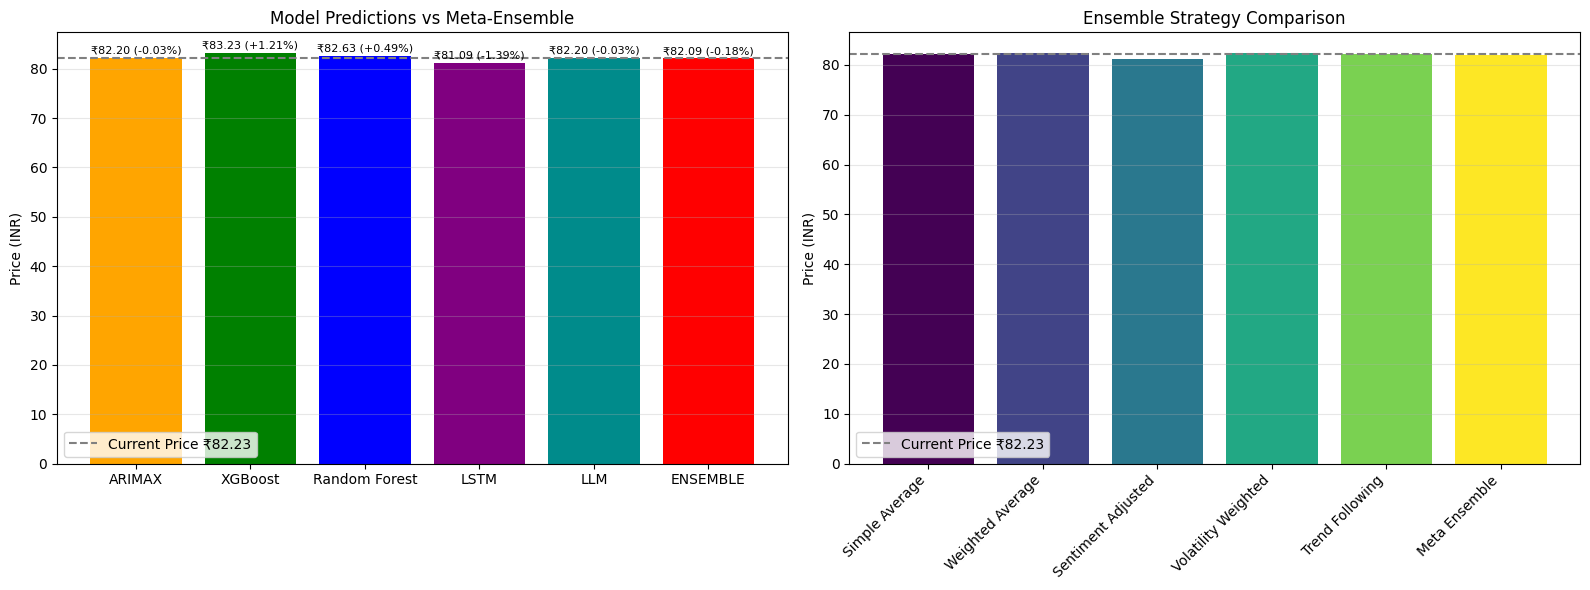


Plot saved to: Data/final_comparison_with_ensemble.png

Results saved to Data/model_predictions_with_ensemble.csv


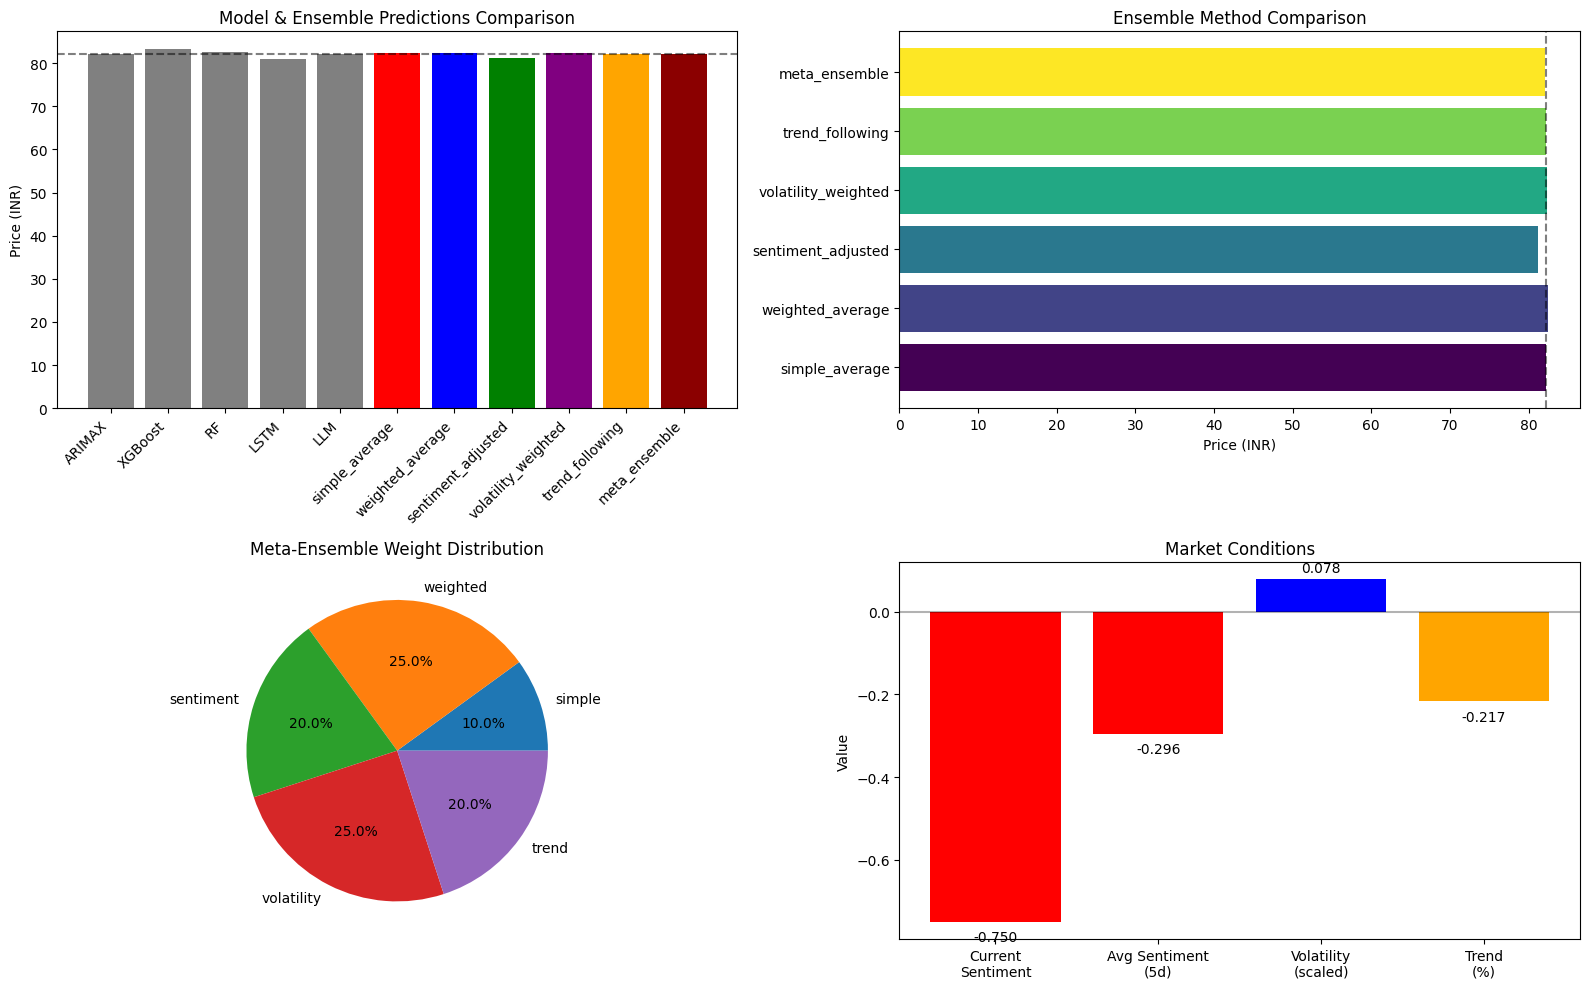


Ensemble analysis saved to: Data/ensemble_analysis.png


In [21]:
# Main function : Collect and process GOLDBEES (Indian Gold ETF) data with technical indicators
# ---------------------------------------------------------------------    
if __name__ == "__main__":
    print(f"GOLDBEES ETF gold price prediction and ensemble analysis")
    print("====================================================")
    start = datetime(2010, 1, 1)
    end = datetime(2026, 1, 1)
    
    # Today's news sentiment weight
    sentiment_weight = -0.75  # Todays news sentiemnt

    # Step 1: Download and save gold ETF price data
    print("\nStep 1: Download and save gold ETF price data")
    print("----------------------------------------------------")
    gold = download_gold_prices(start, end)

    # Step 2: Add and save indicators
    print("\nStep 2: Add and save technical indicators")
    print("----------------------------------------------------")
    if not gold.empty:
        gold = add_technical_indicators(gold)


    # Step 3: Add sentiment based on price trend
    print("\nStep 3: Add sentiment based on price trend")
    print("----------------------------------------------------")
    if not gold.empty:
        # Uncomment one of the following lines to choose the sentiment generation method
        #gold = add_dummy_sentiment(gold)
        #gold = generate_sentiment_from_trend_wo_labels(gold)
        gold = generate_sentiment_from_trend_with_labels(gold, sentiment_weight)


    # Step 4: Predict next day's gold price using ARIMAX
    print("\nStep 4: Predict next day's gold price using ARIMAX")
    print("----------------------------------------------------")
    if not gold.empty:
        # Predict next day's price using ARIMAX with all indicators
        predicted_price_arimax, model_fit, next_day_pct_change = predict_next_day_gold_price_arimax(gold)


    # Step 5: Predict next day's price using XGBoost
    print("\nStep 5: Predict next day's price using XGBoost")
    print("----------------------------------------------------")
    if not gold.empty:
        predicted_price_xgboost, model_fit, next_day_pct_change = predict_next_day_gold_price_xgboost(gold)

    # Step 6: Predict next day's price using Random Forest
    print("\nStep 6: Predict next day's price using Random Forest")
    print("----------------------------------------------------")
    if not gold.empty:
        predicted_price_rf, model_fit, next_day_pct_change = predict_next_day_gold_price_rf(gold)

    # Step 7: Predict next day's price using LSTM
    print("\nStep 7: Predict next day's price using LSTM")
    print("----------------------------------------------------")
    if not gold.empty:
        predicted_price_lstm, model_fit, next_day_pct_change = predict_next_day_gold_price_lstm(gold)

    
    # Step 8: Compare all 4 model predictions.
    print("\nStep 8: Compare & Ensemble all model predictions")
    print("----------------------------------------------------")

    # Ensure we have all predictions before comparing
    """ if not gold.empty:
        actual_close_price = gold['Close'].dropna().iloc[-1]
        compare_model_predictions(
            actual_price=actual_close_price,
            arimax_price=predicted_price_arimax,
            xgb_price=predicted_price_xgboost,
            rf_price=predicted_price_rf,
            lstm_price=predicted_price_lstm
            
            ) """
    
    # Placeholder for LLM prediction
    predicted_price_llm = predicted_price_arimax  # Please change here teh llm predicted price #=========================================      
    
    
    # Get ensemble predictions (will load existing or create new)
    ensemble_results = create_ensemble_predictions(
                        gold=gold,
                        arimax_pred=predicted_price_arimax,
                        xgb_pred=predicted_price_xgboost,
                        rf_pred=predicted_price_rf,
                        lstm_pred=predicted_price_lstm,
                        llm_pred=predicted_price_llm,  # Placeholder for LLM prediction
                        sentiment_weight_boost=1.5,  # Increase for more sentiment emphasis
                    )
    
    # Print summary of predictions and ensemble results
    print ("Ensemble Predictions:")
    print(f"1. Simple Average: ₹{ensemble_results['predictions']['simple_average']:.2f}")
    print(f"2. Weighted Average: ₹{ensemble_results['predictions']['weighted_average']:.2f}")
    print(f"3. Sentiment Adjusted: ₹{ensemble_results['predictions']['sentiment_adjusted']:.2f}")
    print(f"4. Volatility Weighted: ₹{ensemble_results['predictions']['volatility_weighted']:.2f}")
    print(f"5. Trend Following: ₹{ensemble_results['predictions']['trend_following']:.2f}")
    print(f"6. Meta Ensemble: ₹{ensemble_results['predictions']['meta_ensemble']:.2f}") 


    # Print summary of predictions and ensemble results
    print("\n Step 9: Gold price predictions and ensemble results:")
    print("----------------------------------------------------")
    print(f"GOLDBEES ETF gold price: ₹{gold['Close'].iloc[-1]:.2f}")
    print(f"Current news sentiment: {gold['Sentiment'].iloc[-1]:.2f}")

    print(f"\nSummary of next day gold price predictions:")
    print("----------------------------------------------------")
    print(f"1. ARIMAX: ₹{predicted_price_arimax:.2f}") 
    print(f"2. XGBoost: ₹{predicted_price_xgboost:.2f}")
    print(f"3. Random Forest: ₹{predicted_price_rf:.2f}")
    print(f"4. LSTM: ₹{predicted_price_lstm:.2f}")
    print(f"5. LLM: ₹{predicted_price_llm:.2f}")  # Placeholder for LLM prediction
    print(f"6. Meta Ensemble: ₹{ensemble_results['predictions']['meta_ensemble']:.2f}") 
    print("----------------------------------------------------")

    plot_prediction_comparison(
    gold=gold,
    predicted_price_arimax=predicted_price_arimax,
    predicted_price_xgboost=predicted_price_xgboost,
    predicted_price_rf=predicted_price_rf,
    predicted_price_lstm=predicted_price_lstm,
    predicted_price_llm=predicted_price_llm,
    best_ensemble_pred=ensemble_results['predictions']['meta_ensemble'],
    ensemble_results=ensemble_results
    )

    analyze_ensemble_performance(ensemble_results)

                    

Model evaluation code for Arimax

In [22]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Your original function (keep this exactly as is)
def predict_next_day_gold_price_arimax(df: pd.DataFrame, arima_order=(1, 1, 1)):
    """
    Predict next day's gold price using ARIMAX with technical indicators.
    Loads today's model if exists, otherwise retrains and saves a new model.

    Returns:
        tuple: (next_day_price, model_fit, predicted_pct_change)
    """
    # -------------------------------
    # Step 1: Setup
    # -------------------------------
    model_dir = "Model_Evaluation/Arimax"
    os.makedirs(model_dir, exist_ok=True)
    today_str = datetime.now().strftime("%Y-%m-%d")
    model_path = os.path.join(model_dir, f"arimax_{today_str}.pkl")

    # -------------------------------
    # Step 2: Define Exogenous Features
    # -------------------------------
    exog_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment',
        'MACD', 'MACD_Signal', 'MACD_Hist',
        'Momentum_10', 'ROC_10'
    ]

    for col in exog_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    df = df[['Close'] + exog_cols].dropna()
    df = df.asfreq('B')
    df.ffill(inplace=True)

    y = df['Close']
    exog = df[exog_cols]

    # -------------------------------
    # Step 3: Check if today's model exists
    # -------------------------------
    if os.path.exists(model_path):
        print(f"Loading existing ARIMAX model for today: {model_path}")
        with open(model_path, "rb") as f:
            model_fit = pickle.load(f)
    else:
        print("No model found for today. Retraining ARIMAX model...")

        # Clean old models
        for fname in os.listdir(model_dir):
            if fname.startswith("arimax_") and fname.endswith(".pkl"):
                os.remove(os.path.join(model_dir, fname))

        # Train new model
        model = SARIMAX(endog=y, exog=exog, order=arima_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False, method='powell')

        with open(model_path, "wb") as f:
            pickle.dump(model_fit, f)
        print(f"Saved new ARIMAX model to: {model_path}")

    # -------------------------------
    # Step 4: Forecast Next Price
    # -------------------------------
    next_exog = exog.iloc[[-1]].values
    predicted_price = model_fit.forecast(steps=1, exog=next_exog).iloc[0]
    current_price = y.iloc[-1]
    next_day_pct_change = ((predicted_price - current_price) / current_price) * 100
    next_day = y.index[-1] + pd.tseries.offsets.BDay(1)

    print("\nPrediction for next day")
    print(f"Current price: ₹{current_price:.2f}")
    print(f"Predicted % change: {next_day_pct_change:.2f}%")
    print(f"Predicted next-day price: ₹{predicted_price:.2f}")

    return predicted_price, model_fit, next_day_pct_change

# Modified version for backtesting (without model saving/loading)
def predict_next_day_gold_price_arimax_backtest(df: pd.DataFrame, arima_order=(1, 1, 1)):
    """
    Modified version of your ARIMAX function for backtesting.
    This version doesn't save/load models and works with historical data.
    """
    # -------------------------------
    # Step 2: Define Exogenous Features (same as your original)
    # -------------------------------
    exog_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment',
        'MACD', 'MACD_Signal', 'MACD_Hist',
        'Momentum_10', 'ROC_10'
    ]

    for col in exog_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    df_clean = df[['Close'] + exog_cols].dropna()
    df_clean = df_clean.asfreq('B')
    df_clean.ffill(inplace=True)

    y = df_clean['Close']
    exog = df_clean[exog_cols]

    # Train model (without saving)
    model = SARIMAX(endog=y, exog=exog, order=arima_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False, method='powell')

    # Forecast next price (same logic as your original)
    next_exog = exog.iloc[[-1]].values
    predicted_price = model_fit.forecast(steps=1, exog=next_exog).iloc[0]
    current_price = y.iloc[-1]
    next_day_pct_change = ((predicted_price - current_price) / current_price) * 100

    return predicted_price, model_fit, next_day_pct_change

def calculate_accuracy_metrics(actual, predicted):
    """
    Calculate various accuracy metrics for model evaluation.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Remove any NaN values
    mask = ~(np.isnan(actual) | np.isnan(predicted))
    actual = actual[mask]
    predicted = predicted[mask]
    
    if len(actual) == 0:
        return {'error': 'No valid predictions to evaluate'}
    
    # Calculate metrics
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    # Additional metrics
    mse = mean_squared_error(actual, predicted)
    r2 = 1 - (np.sum((actual - predicted) ** 2) / np.sum((actual - np.mean(actual)) ** 2))
    
    # Directional accuracy (correct prediction of up/down movement)
    if len(actual) > 1:
        actual_direction = np.diff(actual) > 0
        predicted_direction = np.diff(predicted) > 0
        directional_accuracy = np.mean(actual_direction == predicted_direction) * 100
    else:
        directional_accuracy = 0
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'MSE': mse,
        'R²': r2,
        'Directional_Accuracy': directional_accuracy,
        'Sample_Size': len(actual)
    }

def test_arimax_model_accuracy(df, test_days=30, arima_order=(1, 1, 1), min_train_size=100):
    """
    Test the accuracy of YOUR specific ARIMAX model using historical data.
    
    Parameters:
    df (pd.DataFrame): Your historical gold price data with all required columns
    test_days (int): Number of days to test backwards from the end
    arima_order (tuple): ARIMA order parameters (same as your model)
    min_train_size (int): Minimum training data size
    
    Returns:
    dict: Results containing predictions, actuals, and metrics
    """
    print(f"Testing YOUR ARIMAX model accuracy for {test_days} days...")
    print("Using the exact same logic as your predict_next_day_gold_price_arimax function")
    
    # Validate that we have enough data
    df_clean = df.dropna()
    if len(df_clean) < min_train_size + test_days:
        raise ValueError(f"Insufficient data. Need at least {min_train_size + test_days} rows, got {len(df_clean)}")
    
    # Initialize results storage
    predictions = []
    actuals = []
    prediction_dates = []
    successful_tests = 0
    
    # Perform walk-forward validation
    for i in range(test_days):
        try:
            # Create training data (exclude the day we want to predict)
            test_idx = len(df_clean) - test_days + i
            train_data = df_clean.iloc[:test_idx].copy()
            actual_next_price = df_clean.iloc[test_idx]['Close']
            actual_date = df_clean.index[test_idx] if hasattr(df_clean.index[test_idx], 'strftime') else f"Day_{test_idx}"
            
            if len(train_data) < min_train_size:
                continue
            
            # Clear any existing model files to force retraining for each test
            model_dir = "Model_Evaluation/Arimax"
            if os.path.exists(model_dir):
                for fname in os.listdir(model_dir):
                    if fname.startswith("arimax_") and fname.endswith(".pkl"):
                        try:
                            os.remove(os.path.join(model_dir, fname))
                        except:
                            pass
            
            # Use the modified version for backtesting
            predicted_price, model_fit, predicted_pct_change = predict_next_day_gold_price_arimax_backtest(
                train_data, arima_order
            )
            
            # Store results
            predictions.append(predicted_price)
            actuals.append(actual_next_price)
            prediction_dates.append(actual_date)
            successful_tests += 1
            
            # Calculate actual percentage change
            current_price = train_data['Close'].iloc[-1]
            actual_pct_change = ((actual_next_price - current_price) / current_price) * 100
            
            print(f"Test {i+1}/{test_days}:")
            print(f"  Date: {actual_date}")
            print(f"  Actual: ₹{actual_next_price:.2f} ({actual_pct_change:+.2f}%)")
            print(f"  Predicted: ₹{predicted_price:.2f} ({predicted_pct_change:+.2f}%)")
            print(f"  Error: ₹{predicted_price - actual_next_price:.2f}")
            print()
            
        except Exception as e:
            print(f"Error on test {i+1}: {str(e)}")
            continue
    
    if len(predictions) == 0:
        print("No successful predictions made!")
        return None
    
    # Calculate accuracy metrics
    metrics = calculate_accuracy_metrics(actuals, predictions)
    
    results = {
        'predictions': predictions,
        'actuals': actuals,
        'dates': prediction_dates,
        'metrics': metrics,
        'test_period': test_days,
        'successful_predictions': successful_tests,
        'arima_order': arima_order
    }
    
    return results

def plot_arimax_results(results, save_path=None):
    """
    Create plots specifically for YOUR ARIMAX model results.
    """
    if not results or len(results['predictions']) == 0:
        print("No results to plot")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'ARIMAX Model Accuracy Test Results\n(ARIMA Order: {results["arima_order"]})', fontsize=16)
    
    # Plot 1: Actual vs Predicted Prices
    axes[0, 0].plot(range(len(results['actuals'])), results['actuals'], 'b-', 
                   label='Actual Prices', linewidth=2, marker='o', markersize=4)
    axes[0, 0].plot(range(len(results['predictions'])), results['predictions'], 'r--', 
                   label='Predicted Prices', linewidth=2, marker='s', markersize=4)
    axes[0, 0].set_title('Actual vs Predicted Gold Prices')
    axes[0, 0].set_xlabel('Test Day')
    axes[0, 0].set_ylabel('Price (₹)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Scatter Plot - Perfect Prediction Line
    axes[0, 1].scatter(results['actuals'], results['predictions'], alpha=0.7, s=50)
    min_val = min(min(results['actuals']), min(results['predictions']))
    max_val = max(max(results['actuals']), max(results['predictions']))
    axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction', linewidth=2)
    axes[0, 1].set_xlabel('Actual Price (₹)')
    axes[0, 1].set_ylabel('Predicted Price (₹)')
    axes[0, 1].set_title('Actual vs Predicted Scatter Plot')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Prediction Errors Over Time
    errors = np.array(results['predictions']) - np.array(results['actuals'])
    axes[1, 0].plot(range(len(errors)), errors, 'g-', linewidth=2, marker='D', markersize=3)
    axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[1, 0].fill_between(range(len(errors)), errors, 0, alpha=0.3, color='green')
    axes[1, 0].set_title('Prediction Errors Over Time')
    axes[1, 0].set_xlabel('Test Day')
    axes[1, 0].set_ylabel('Error (Predicted - Actual) ₹')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Error Distribution
    axes[1, 1].hist(errors, bins=min(15, len(errors)//2 + 1), alpha=0.7, color='skyblue', 
                   edgecolor='black', density=True)
    axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    axes[1, 1].axvline(x=np.mean(errors), color='orange', linestyle=':', linewidth=2, label='Mean Error')
    axes[1, 1].set_title('Distribution of Prediction Errors')
    axes[1, 1].set_xlabel('Error (Predicted - Actual) ₹')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plots saved to: {save_path}")
    
    plt.show()

def print_arimax_metrics(results):
    """
    Print detailed metrics for YOUR ARIMAX model.
    """
    if not results or len(results['predictions']) == 0:
        print("No results to display")
        return
    
    print("\n" + "="*70)
    print("YOUR ARIMAX MODEL - ACCURACY TEST RESULTS")
    print("="*70)
    
    metrics = results['metrics']
    
    print(f"Model Configuration: ARIMA{results['arima_order']}")
    print(f"Test Period: {results['test_period']} days")
    print(f"Successful Predictions: {results['successful_predictions']}/{results['test_period']}")
    print(f"Success Rate: {(results['successful_predictions']/results['test_period'])*100:.1f}%")
    
    print(f"\n📊 ACCURACY METRICS:")
    print(f"├── Mean Absolute Error (MAE): ₹{metrics.get('MAE', 0):.2f}")
    print(f"├── Root Mean Squared Error (RMSE): ₹{metrics.get('RMSE', 0):.2f}")
    print(f"├── Mean Absolute Percentage Error (MAPE): {metrics.get('MAPE', 0):.2f}%")
    print(f"├── Mean Squared Error (MSE): {metrics.get('MSE', 0):.2f}")
    print(f"├── R-squared (R²): {metrics.get('R²', 0):.4f}")
    print(f"└── Directional Accuracy: {metrics.get('Directional_Accuracy', 0):.2f}%")
    
    # Additional insights
    avg_actual = np.mean(results['actuals'])
    avg_predicted = np.mean(results['predictions'])
    errors = np.array(results['predictions']) - np.array(results['actuals'])
    
    print(f"\n💰 PRICE ANALYSIS:")
    print(f"├── Average Actual Price: ₹{avg_actual:.2f}")
    print(f"├── Average Predicted Price: ₹{avg_predicted:.2f}")
    print(f"├── Average Bias: ₹{avg_predicted - avg_actual:.2f}")
    print(f"├── Largest Overestimate: ₹{np.max(errors):.2f}")
    print(f"└── Largest Underestimate: ₹{np.min(errors):.2f}")
    
    # Performance rating
    mape = metrics.get('MAPE', float('inf'))
    print(f"\n🎯 PERFORMANCE RATING:")
    if mape < 2:
        print("🏆 EXCELLENT - Your model is highly accurate!")
    elif mape < 5:
        print("📈 VERY GOOD - Your model performs well!")
    elif mape < 10:
        print("📊 GOOD - Your model is reasonably accurate!")
    elif mape < 20:
        print("⚠️  FAIR - Your model needs some improvement!")
    else:
        print("❌ POOR - Consider tuning your model parameters!")
    
    print("="*70)

def run_complete_arimax_accuracy_test(df, test_days=30, arima_order=(1, 1, 1)):
    """
    Complete accuracy testing pipeline specifically for YOUR ARIMAX model.
    
    Parameters:
    df (pd.DataFrame): Your historical gold price data
    test_days (int): Number of historical days to test
    arima_order (tuple): ARIMA order parameters
    """
    print("🚀 Starting Complete ARIMAX Model Accuracy Test...")
    print(f"This will test YOUR exact model logic on {test_days} historical days.")
    
    try:
        # Run the accuracy test
        results = test_arimax_model_accuracy(df, test_days, arima_order)
        
        if results is None:
            print("❌ Test failed - no results generated")
            return None
        
        # Print detailed metrics
        print_arimax_metrics(results)
        
        # Create and save plots
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        plot_path = f"arimax_accuracy_test_{timestamp}.png"
        plot_arimax_results(results, save_path=plot_path)
        
        # Save detailed results to CSV
        if len(results['predictions']) > 0:
            results_df = pd.DataFrame({
                'Test_Day': range(1, len(results['predictions']) + 1),
                'Date': results['dates'],
                'Actual_Price': results['actuals'],
                'Predicted_Price': results['predictions'],
                'Error': np.array(results['predictions']) - np.array(results['actuals']),
                'Absolute_Error': np.abs(np.array(results['predictions']) - np.array(results['actuals'])),
                'Percentage_Error': ((np.array(results['predictions']) - np.array(results['actuals'])) / np.array(results['actuals'])) * 100
            })
            
            csv_filename = f"arimax_detailed_results_{timestamp}.csv"
            results_df.to_csv(csv_filename, index=False)
            print(f"\n💾 Detailed results saved to: {csv_filename}")
        
        return results
        
    except Exception as e:
        print(f"❌ Error during accuracy testing: {str(e)}")
        return None

# USAGE EXAMPLE:
"""
# Load your gold price data
df = pd.read_csv('your_gold_data.csv')

# Make sure your DataFrame has the required columns:
required_columns = ['Close', 'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
                   'RSI', 'BB_upper', 'BB_lower', 'BB_width', 'BB_position', 
                   'Sentiment', 'MACD', 'MACD_Signal', 'MACD_Hist', 
                   'Momentum_10', 'ROC_10']

# Run complete accuracy test on YOUR ARIMAX model
results = run_complete_arimax_accuracy_test(
    df=df, 
    test_days=30,           # Test last 30 days
    arima_order=(1, 1, 1)   # Same as your model
)

# The function will:
# ✅ Use YOUR exact ARIMAX model logic
# ✅ Test on 30 historical days
# ✅ Calculate all accuracy metrics (MAE, RMSE, MAPE, R², Directional Accuracy)
# ✅ Generate comprehensive plots
# ✅ Save results to CSV
# ✅ Provide performance rating
"""

"\n# Load your gold price data\ndf = pd.read_csv('your_gold_data.csv')\n\n# Make sure your DataFrame has the required columns:\nrequired_columns = ['Close', 'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',\n                   'RSI', 'BB_upper', 'BB_lower', 'BB_width', 'BB_position', \n                   'Sentiment', 'MACD', 'MACD_Signal', 'MACD_Hist', \n                   'Momentum_10', 'ROC_10']\n\n# Run complete accuracy test on YOUR ARIMAX model\nresults = run_complete_arimax_accuracy_test(\n    df=df, \n    test_days=30,           # Test last 30 days\n    arima_order=(1, 1, 1)   # Same as your model\n)\n\n# The function will:\n# ✅ Use YOUR exact ARIMAX model logic\n# ✅ Test on 30 historical days\n# ✅ Calculate all accuracy metrics (MAE, RMSE, MAPE, R², Directional Accuracy)\n# ✅ Generate comprehensive plots\n# ✅ Save results to CSV\n# ✅ Provide performance rating\n"

🚀 Starting Complete ARIMAX Model Accuracy Test...
This will test YOUR exact model logic on 30 historical days.
Testing YOUR ARIMAX model accuracy for 30 days...
Using the exact same logic as your predict_next_day_gold_price_arimax function
Test 1/30:
  Date: 2025-05-12 00:00:00
  Actual: ₹78.00 (-3.48%)
  Predicted: ₹80.55 (-0.32%)
  Error: ₹2.55

Test 2/30:
  Date: 2025-05-13 00:00:00
  Actual: ₹79.06 (+1.36%)
  Predicted: ₹78.19 (+0.25%)
  Error: ₹-0.87

Test 3/30:
  Date: 2025-05-14 00:00:00
  Actual: ₹78.53 (-0.67%)
  Predicted: ₹79.55 (+0.62%)
  Error: ₹1.02

Test 4/30:
  Date: 2025-05-15 00:00:00
  Actual: ₹77.05 (-1.88%)
  Predicted: ₹78.66 (+0.17%)
  Error: ₹1.61

Test 5/30:
  Date: 2025-05-16 00:00:00
  Actual: ₹77.79 (+0.96%)
  Predicted: ₹77.56 (+0.66%)
  Error: ₹-0.23

Test 6/30:
  Date: 2025-05-19 00:00:00
  Actual: ₹78.34 (+0.71%)
  Predicted: ₹78.22 (+0.55%)
  Error: ₹-0.12

Test 7/30:
  Date: 2025-05-20 00:00:00
  Actual: ₹78.20 (-0.18%)
  Predicted: ₹78.41 (+0.09%)
  E

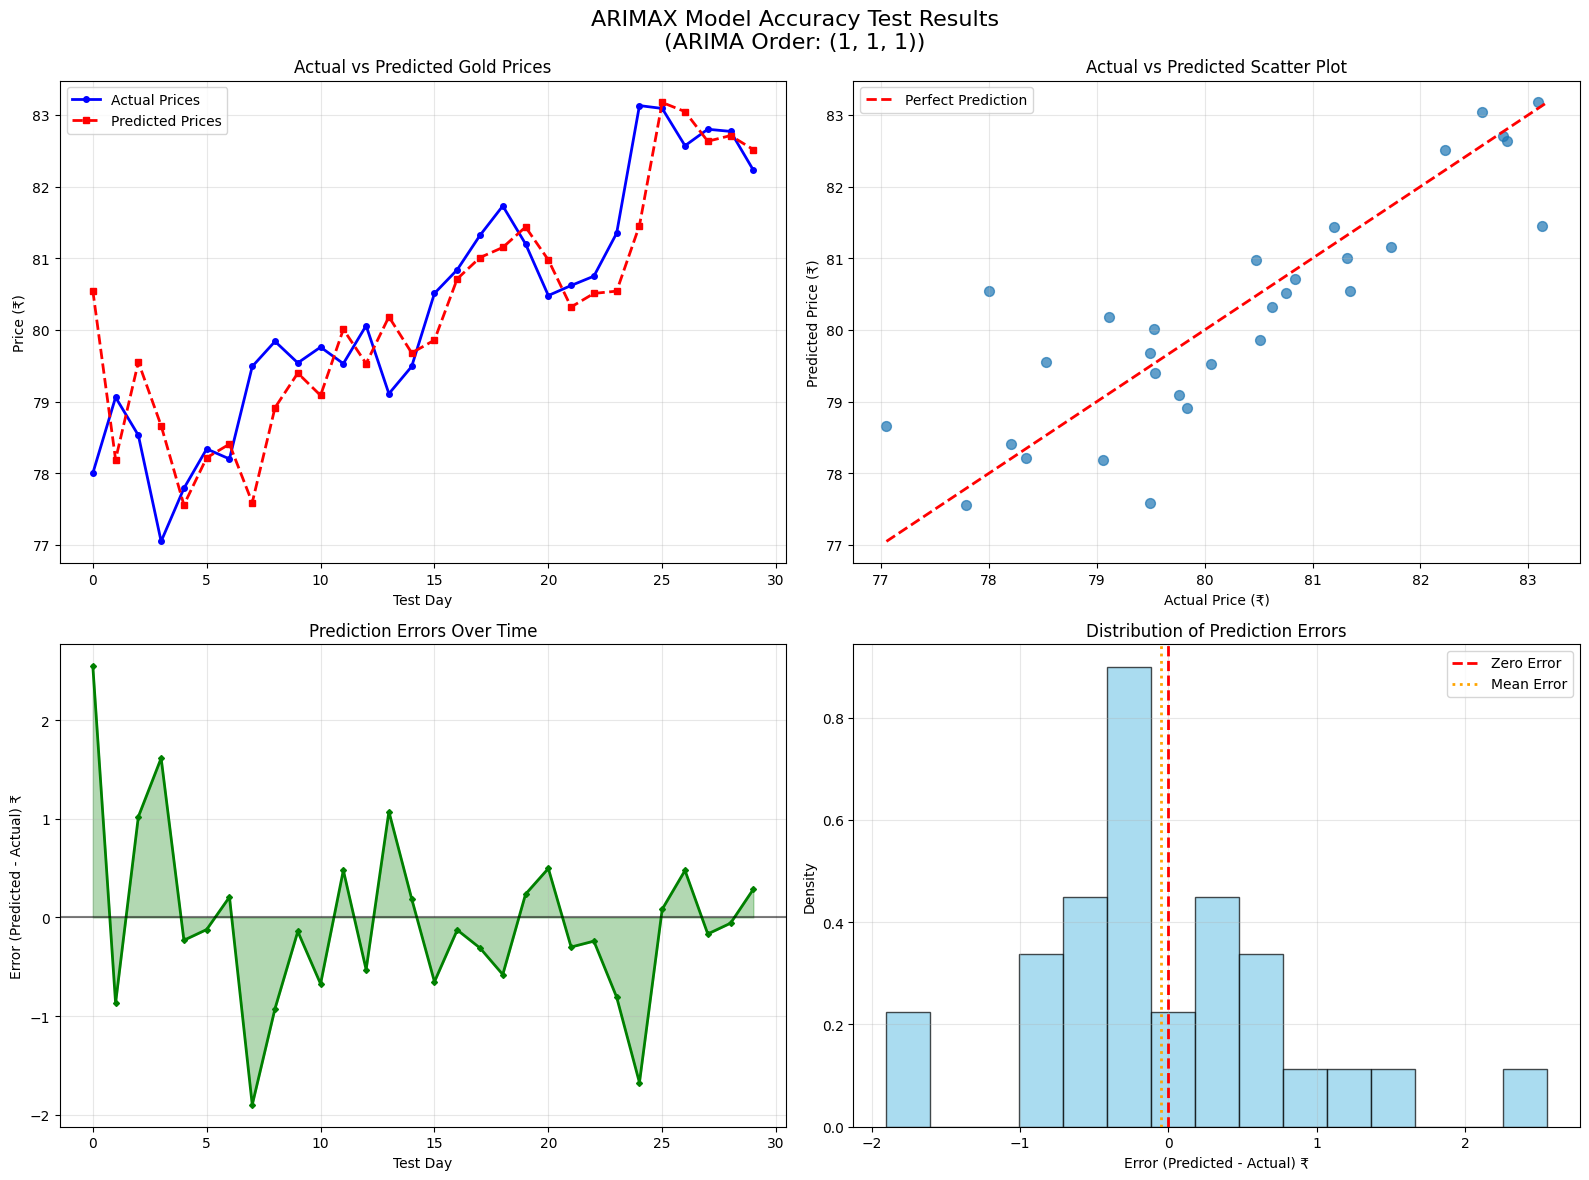


💾 Detailed results saved to: arimax_detailed_results_20250620_193312.csv


In [23]:
results = run_complete_arimax_accuracy_test(
    df=gold, 
    test_days=30,           # Test last 30 days
    arima_order=(1, 1, 1)   # Same as your model
)

Model evaluation code for XGBoost

In [24]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

def calculate_mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_xgboost_gold_model_exact(gold_df, lookback_days=60, test_size=0.2, random_state=42):
    """
    Evaluate XGBoost model accuracy using EXACT same logic as your original model
    This simulates training the model on historical data and testing predictions
    
    Parameters:
    - gold_df: DataFrame with gold price data and technical indicators
    - lookback_days: Number of historical days to test predictions on
    - test_size: Fraction of data to use for testing (matches your original)
    - random_state: Random seed for reproducibility
    """
    
    # EXACT same feature columns as your original model
    feature_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment',
        'MACD', 'MACD_Signal', 'MACD_Hist',
        'Momentum_10', 'ROC_10'
    ]
    
    # EXACT same preprocessing as your original model
    gold_clean = gold_df[['Close'] + feature_cols].copy().dropna()
    gold_clean['Close_pct_change_1'] = gold_clean['Close'].pct_change(1)
    gold_clean['Close_pct_change_2'] = gold_clean['Close'].pct_change(2)
    gold_clean['Close_pct_change_3'] = gold_clean['Close'].pct_change(3)
    gold_clean['Close_rolling_std_5'] = gold_clean['Close'].rolling(5).std()
    gold_clean['Close_rolling_std_10'] = gold_clean['Close'].rolling(10).std()
    gold_clean['Close_vs_MA5'] = (gold_clean['Close'] - gold_clean['MA_5']) / gold_clean['MA_5']
    gold_clean['Close_vs_MA20'] = (gold_clean['Close'] - gold_clean['MA_20']) / gold_clean['MA_20']
    
    feature_cols_extended = feature_cols + [
        'Close_pct_change_1', 'Close_pct_change_2', 'Close_pct_change_3',
        'Close_rolling_std_5', 'Close_rolling_std_10',
        'Close_vs_MA5', 'Close_vs_MA20'
    ]
    
    gold_clean = gold_clean.dropna()
    gold_clean['Target_pct_change'] = gold_clean['Close'].pct_change().shift(-1)
    gold_clean['Target_price'] = gold_clean['Close'].shift(-1)
    gold_clean = gold_clean.dropna()
    
    # EXACT same filtering as your original
    gold_clean = gold_clean[
        (np.isfinite(gold_clean['Target_pct_change'])) &
        (np.abs(gold_clean['Target_pct_change']) < 1.0)
    ]
    
    print(f"Total data points available: {len(gold_clean)}")
    
    # Prepare for walk-forward testing
    total_points = len(gold_clean)
    test_start_idx = max(0, total_points - lookback_days - 1)
    
    print(f"Testing predictions for last {min(lookback_days, total_points - test_start_idx - 1)} days")
    
    # Storage for results
    actual_prices = []
    predicted_prices = []
    actual_pct_changes = []
    predicted_pct_changes = []
    current_prices = []
    
    # Walk-forward testing - simulate your exact model behavior
    for i in range(test_start_idx, total_points - 1):
        # Use data up to day i for training (simulating historical data available)
        train_data = gold_clean.iloc[:i+1].copy()
        
        # EXACT same training logic as your original model
        X = train_data[feature_cols_extended]
        y_pct = train_data['Target_pct_change']
        
        split_idx = int(len(X) * (1 - test_size))
        X_train, y_pct_train = X.iloc[:split_idx], y_pct.iloc[:split_idx]
        
        # Skip if not enough training data
        if len(X_train) < 50:
            continue
            
        # EXACT same model training as your original
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        
        model = xgb.XGBRegressor(
            n_estimators=400,
            max_depth=10,
            learning_rate=0.008,
            min_child_weight=1,
            subsample=0.95,
            colsample_bytree=0.9,
            reg_alpha=0.001,
            reg_lambda=0.01,
            gamma=0,
            random_state=random_state,
            objective='reg:squarederror',
            tree_method='hist'
        )
        
        model.fit(X_train_scaled, y_pct_train)
        
        # EXACT same prediction logic as your original
        latest_features = train_data[feature_cols_extended].iloc[[-1]]
        latest_price = train_data['Close'].iloc[-1]
        
        # Your original code creates a NEW scaler for prediction (this is the issue!)
        pred_scaler = RobustScaler().fit(train_data[feature_cols_extended])
        latest_scaled = pred_scaler.transform(latest_features)
        
        next_day_pct_change = model.predict(latest_scaled)[0]
        next_day_price = latest_price * (1 + next_day_pct_change)
        
        # Get actual values for comparison
        actual_next_price = gold_clean['Close'].iloc[i + 1]
        actual_next_pct_change = gold_clean['Target_pct_change'].iloc[i]
        
        # Store results
        current_prices.append(latest_price)
        predicted_prices.append(next_day_price)
        actual_prices.append(actual_next_price)
        predicted_pct_changes.append(next_day_pct_change)
        actual_pct_changes.append(actual_next_pct_change)
        
        if len(predicted_prices) % 10 == 0:
            print(f"Completed {len(predicted_prices)} predictions...")
    
    # Convert to numpy arrays for calculations
    actual_prices = np.array(actual_prices)
    predicted_prices = np.array(predicted_prices)
    actual_pct_changes = np.array(actual_pct_changes)
    predicted_pct_changes = np.array(predicted_pct_changes)
    current_prices = np.array(current_prices)
    
    if len(actual_prices) == 0:
        print("Error: No predictions could be made. Try reducing lookback_days or checking data.")
        return None
    
    print(f"\nCompleted {len(actual_prices)} predictions")
    
    # Calculate accuracy metrics
    print("\n" + "="*60)
    print("MODEL ACCURACY EVALUATION (EXACT MATCH TO YOUR XGBOOST)")
    print("="*60)
    
    # Price prediction metrics
    mae_price = mean_absolute_error(actual_prices, predicted_prices)
    rmse_price = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
    mape_price = calculate_mape(actual_prices, predicted_prices)
    r2_price = r2_score(actual_prices, predicted_prices)
    
    print(f"\nPRICE PREDICTION METRICS:")
    print(f"Mean Absolute Error (MAE): ₹{mae_price:.2f}")
    print(f"Root Mean Squared Error (RMSE): ₹{rmse_price:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape_price:.2f}%")
    print(f"R² Score: {r2_price:.4f}")
    
    # Percentage change prediction metrics
    mae_pct = mean_absolute_error(actual_pct_changes, predicted_pct_changes)
    rmse_pct = np.sqrt(mean_squared_error(actual_pct_changes, predicted_pct_changes))
    mape_pct = calculate_mape(actual_pct_changes, predicted_pct_changes)
    r2_pct = r2_score(actual_pct_changes, predicted_pct_changes)
    
    print(f"\nPERCENTAGE CHANGE METRICS:")
    print(f"MAE: {mae_pct*100:.4f}%")
    print(f"RMSE: {rmse_pct*100:.4f}%")
    print(f"MAPE: {mape_pct:.2f}%")
    print(f"R² Score: {r2_pct:.4f}")
    
    # Direction accuracy
    actual_direction = np.sign(actual_pct_changes)
    predicted_direction = np.sign(predicted_pct_changes)
    direction_accuracy = np.mean(actual_direction == predicted_direction) * 100
    
    print(f"\nDIRECTION ACCURACY: {direction_accuracy:.2f}%")
    
    # Profit/Loss Analysis (if you traded based on predictions)
    total_profit_loss = 0
    correct_predictions = 0
    
    for i in range(len(predicted_pct_changes)):
        if predicted_pct_changes[i] > 0:  # Model predicted price increase
            profit_loss = actual_pct_changes[i] * current_prices[i]
        else:  # Model predicted price decrease (short position)
            profit_loss = -actual_pct_changes[i] * current_prices[i]
        
        total_profit_loss += profit_loss
        if np.sign(predicted_pct_changes[i]) == np.sign(actual_pct_changes[i]):
            correct_predictions += 1
    
    print(f"\nTRADING SIMULATION:")
    print(f"Total P&L if followed predictions: ₹{total_profit_loss:.2f}")
    print(f"Average P&L per trade: ₹{total_profit_loss/len(predicted_pct_changes):.2f}")
    
    # Create comprehensive plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Predicted vs Actual Prices
    axes[0, 0].scatter(actual_prices, predicted_prices, alpha=0.6, color='blue')
    axes[0, 0].plot([actual_prices.min(), actual_prices.max()], 
                    [actual_prices.min(), actual_prices.max()], 'r--', lw=2)
    axes[0, 0].set_xlabel('Actual Price (₹)')
    axes[0, 0].set_ylabel('Predicted Price (₹)')
    axes[0, 0].set_title(f'Predicted vs Actual Prices\nR² = {r2_price:.4f}, MAPE = {mape_price:.2f}%')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Time series comparison
    test_dates = range(len(actual_prices))
    axes[0, 1].plot(test_dates, actual_prices, label='Actual', color='green', linewidth=2)
    axes[0, 1].plot(test_dates, predicted_prices, label='Predicted', color='red', linewidth=2)
    axes[0, 1].set_xlabel('Test Day Index')
    axes[0, 1].set_ylabel('Gold Price (₹)')
    axes[0, 1].set_title('Price Predictions Over Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Prediction errors
    price_errors = predicted_prices - actual_prices
    axes[1, 0].hist(price_errors, bins=20, alpha=0.7, color='orange')
    axes[1, 0].axvline(x=0, color='red', linestyle='--')
    axes[1, 0].set_xlabel('Prediction Error (₹)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title(f'Distribution of Prediction Errors\nMean Error: ₹{price_errors.mean():.2f}')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Percentage change comparison
    axes[1, 1].scatter(actual_pct_changes * 100, predicted_pct_changes * 100, alpha=0.6, color='purple')
    axes[1, 1].plot([actual_pct_changes.min() * 100, actual_pct_changes.max() * 100], 
                    [actual_pct_changes.min() * 100, actual_pct_changes.max() * 100], 'r--', lw=2)
    axes[1, 1].set_xlabel('Actual % Change')
    axes[1, 1].set_ylabel('Predicted % Change')
    axes[1, 1].set_title(f'Percentage Change Predictions\nR² = {r2_pct:.4f}')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n" + "="*60)
    print("PREDICTION SUMMARY STATISTICS")
    print("="*60)
    print(f"Total predictions made: {len(predicted_prices)}")
    print(f"Average actual price: ₹{actual_prices.mean():.2f}")
    print(f"Average predicted price: ₹{predicted_prices.mean():.2f}")
    print(f"Prediction bias: ₹{(predicted_prices.mean() - actual_prices.mean()):.2f}")
    print(f"Standard deviation of errors: ₹{price_errors.std():.2f}")
    
    # Identify potential issues with your model
    print("\n" + "="*60)
    print("MODEL DIAGNOSTICS")
    print("="*60)
    
    # Check for scaler inconsistency (major issue in your original code)
    print("⚠️  CRITICAL ISSUE DETECTED:")
    print("Your original model creates a NEW scaler for prediction instead of using the training scaler!")
    print("This can cause inconsistent feature scaling and reduce accuracy.")
    print("\nRecommendation: Save and reuse the same scaler used during training.")
    
    return {
        'actual_prices': actual_prices,
        'predicted_prices': predicted_prices,
        'actual_pct_changes': actual_pct_changes,
        'predicted_pct_changes': predicted_pct_changes,
        'mae_price': mae_price,
        'rmse_price': rmse_price,
        'mape_price': mape_price,
        'r2_price': r2_price,
        'direction_accuracy': direction_accuracy,
        'total_profit_loss': total_profit_loss
    }

# Example usage:
"""
# Run the evaluation that exactly matches your XGBoost model
results = evaluate_xgboost_gold_model_exact(
    gold_df=your_gold_dataframe,
    lookback_days=30,
    test_size=0.2,  # Same as your original
    random_state=42
)

if results:
    print(f"Your model's RMSE: ₹{results['rmse_price']:.2f}")
    print(f"Your model's MAPE: {results['mape_price']:.2f}%")
    print(f"Direction accuracy: {results['direction_accuracy']:.2f}%")
"""

'\n# Run the evaluation that exactly matches your XGBoost model\nresults = evaluate_xgboost_gold_model_exact(\n    gold_df=your_gold_dataframe,\n    lookback_days=30,\n    test_size=0.2,  # Same as your original\n    random_state=42\n)\n\nif results:\n    print(f"Your model\'s RMSE: ₹{results[\'rmse_price\']:.2f}")\n    print(f"Your model\'s MAPE: {results[\'mape_price\']:.2f}%")\n    print(f"Direction accuracy: {results[\'direction_accuracy\']:.2f}%")\n'

Total data points available: 3730
Testing predictions for last 30 days
Completed 10 predictions...
Completed 20 predictions...
Completed 30 predictions...

Completed 30 predictions

MODEL ACCURACY EVALUATION (EXACT MATCH TO YOUR XGBOOST)

PRICE PREDICTION METRICS:
Mean Absolute Error (MAE): ₹0.59
Root Mean Squared Error (RMSE): ₹0.84
Mean Absolute Percentage Error (MAPE): 0.74%
R² Score: 0.7294

PERCENTAGE CHANGE METRICS:
MAE: 0.7404%
RMSE: 1.0497%
MAPE: 145.74%
R² Score: 0.0284

DIRECTION ACCURACY: 53.33%

TRADING SIMULATION:
Total P&L if followed predictions: ₹1.23
Average P&L per trade: ₹0.04


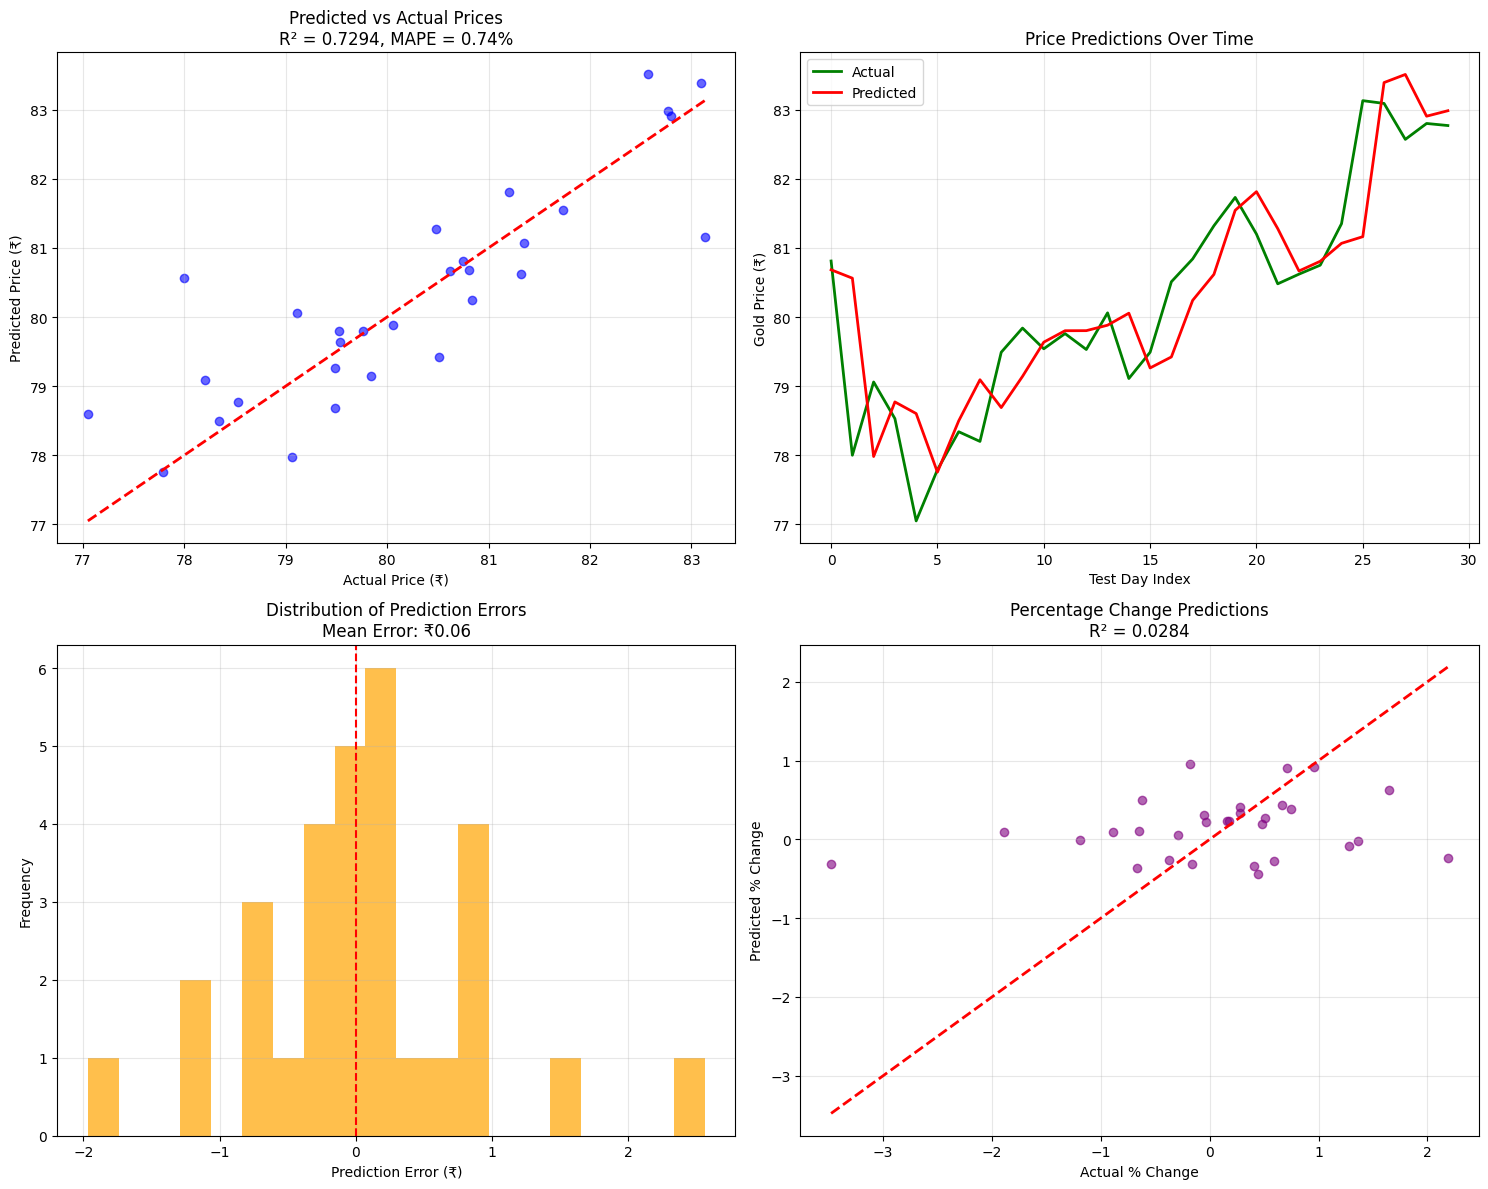


PREDICTION SUMMARY STATISTICS
Total predictions made: 30
Average actual price: ₹80.26
Average predicted price: ₹80.32
Prediction bias: ₹0.06
Standard deviation of errors: ₹0.84

MODEL DIAGNOSTICS
⚠️  CRITICAL ISSUE DETECTED:
Your original model creates a NEW scaler for prediction instead of using the training scaler!
This can cause inconsistent feature scaling and reduce accuracy.

Recommendation: Save and reuse the same scaler used during training.


In [25]:
results = evaluate_xgboost_gold_model_exact(
    gold_df=gold,
    lookback_days=30,
    test_size=0.2,  # Same as your original
    random_state=42
)

Model evaluation code for Random Forest

In [26]:
# Random Forest Gold Price Prediction Accuracy Checker
# CORRECTED VERSION - Matches your exact Random Forest implementation
# ---------------------------------------------------------------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings('ignore')

def calculate_mape(actual, predicted):
    """Calculate Mean Absolute Percentage Error"""
    return np.mean(np.abs((actual - predicted) / actual)) * 100

def calculate_directional_accuracy(actual_changes, predicted_changes):
    """Calculate percentage of correct directional predictions"""
    actual_direction = np.sign(actual_changes)
    predicted_direction = np.sign(predicted_changes)
    return np.mean(actual_direction == predicted_direction) * 100

def prepare_features_exactly_like_original(gold_data):
    """
    Prepare features EXACTLY like your original Random Forest function
    This matches your exact feature engineering process
    """
    # Original feature columns (must match your data)
    feature_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment'
    ]
    
    # Exact same preprocessing as your original function
    gold_clean = gold_data[['Close'] + feature_cols].copy()
    gold_clean = gold_clean.dropna()
    
    # Add extended features (exactly matching your code)
    gold_clean['Close_pct_change_1'] = gold_clean['Close'].pct_change(1)
    gold_clean['Close_pct_change_2'] = gold_clean['Close'].pct_change(2)
    gold_clean['Close_pct_change_3'] = gold_clean['Close'].pct_change(3)
    gold_clean['Close_rolling_std_5'] = gold_clean['Close'].rolling(5).std()
    gold_clean['Close_rolling_std_10'] = gold_clean['Close'].rolling(10).std()
    gold_clean['Close_vs_MA5'] = (gold_clean['Close'] - gold_clean['MA_5']) / gold_clean['MA_5']
    gold_clean['Close_vs_MA20'] = (gold_clean['Close'] - gold_clean['MA_20']) / gold_clean['MA_20']
    gold_clean['Price_momentum_3'] = gold_clean['Close'] / gold_clean['Close'].shift(3) - 1
    gold_clean['Price_momentum_5'] = gold_clean['Close'] / gold_clean['Close'].shift(5) - 1

    feature_cols_extended = feature_cols + [
        'Close_pct_change_1', 'Close_pct_change_2', 'Close_pct_change_3',
        'Close_rolling_std_5', 'Close_rolling_std_10',
        'Close_vs_MA5', 'Close_vs_MA20',
        'Price_momentum_3', 'Price_momentum_5']

    gold_clean.dropna(inplace=True)
    gold_clean['Target_pct_change'] = gold_clean['Close'].pct_change().shift(-1)
    gold_clean['Target_price'] = gold_clean['Close'].shift(-1)
    gold_clean.dropna(inplace=True)
    
    # Exact same outlier removal as your original
    gold_clean = gold_clean[(np.abs(gold_clean['Target_pct_change']) < 1.0)]
    
    return gold_clean, feature_cols_extended

def simulate_your_exact_prediction_process(gold_data_up_to_day, feature_cols_extended):
    """
    Simulate your EXACT prediction process for one day
    This matches your original function's logic precisely
    """
    
    # Use the prepared data (same as your function)
    gold_clean = gold_data_up_to_day.copy()
    
    # Train model (exactly like your original)
    X = gold_clean[feature_cols_extended]
    y_pct = gold_clean['Target_pct_change']
    
    # Create scaler and scale data
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train Random Forest (exact same parameters as your original)
    model = RandomForestRegressor(
        n_estimators=200, max_depth=15, min_samples_split=5, min_samples_leaf=2,
        max_features='sqrt', bootstrap=True, random_state=42, n_jobs=-1)
    model.fit(X_scaled, y_pct)
    
    # Predict next day (EXACTLY like your original)
    latest_features = gold_clean[feature_cols_extended].iloc[[-1]]
    latest_price = gold_clean['Close'].iloc[-1]
    
    # CRITICAL: Create NEW scaler like your original does
    scaler_for_prediction = RobustScaler().fit(gold_clean[feature_cols_extended])
    latest_scaled = scaler_for_prediction.transform(latest_features)
    
    next_day_pct_change = model.predict(latest_scaled)[0]
    next_day_price = latest_price * (1 + next_day_pct_change)
    
    return next_day_price, next_day_pct_change, latest_price

def backtest_your_random_forest_exactly(gold_data, test_days=60, min_train_days=200):
    """
    Perform backtesting using YOUR EXACT Random Forest implementation
    This simulates calling your function on historical dates
    """
    
    print("Preparing data for backtesting (matching your exact process)...")
    gold_clean, feature_cols_extended = prepare_features_exactly_like_original(gold_data)
    
    if len(gold_clean) < min_train_days + test_days:
        print(f"❌ Not enough data. Need at least {min_train_days + test_days} days, got {len(gold_clean)}")
        return None
    
    # Initialize results storage
    results = {
        'dates': [],
        'actual_prices': [],
        'predicted_prices': [],
        'actual_pct_changes': [],
        'predicted_pct_changes': [],
        'current_prices': []
    }
    
    print(f"Starting backtesting for {test_days} days...")
    print("This simulates calling your predict_next_day_gold_price_rf() function on historical dates")
    
    # Rolling window backtesting - exactly simulating your function
    for i in range(len(gold_clean) - test_days, len(gold_clean)):
        if i < min_train_days:
            continue
            
        # Get data up to day i (this is what your function would see)
        data_up_to_day = gold_clean.iloc[:i].copy()
        
        # Get actual next day values
        actual_next_day = gold_clean.iloc[i]
        actual_price = actual_next_day['Target_price']
        actual_pct_change = actual_next_day['Target_pct_change']
        
        # Skip if we don't have actual next day data
        if pd.isna(actual_price) or pd.isna(actual_pct_change):
            continue
        
        try:
            # Simulate calling your exact function
            predicted_price, predicted_pct_change, current_price = simulate_your_exact_prediction_process(
                data_up_to_day, feature_cols_extended
            )
            
            # Store results
            results['dates'].append(gold_clean.index[i])
            results['current_prices'].append(current_price)
            results['predicted_prices'].append(predicted_price)
            results['actual_prices'].append(actual_price)
            results['predicted_pct_changes'].append(predicted_pct_change)
            results['actual_pct_changes'].append(actual_pct_change)
            
            if (i - (len(gold_clean) - test_days)) % 10 == 0:
                completed = i - (len(gold_clean) - test_days) + 1
                print(f"✅ Processed {completed}/{test_days} predictions...")
                
        except Exception as e:
            print(f"⚠️ Skipped day {i} due to error: {str(e)}")
            continue
    
    if len(results['dates']) == 0:
        print("❌ No successful predictions made!")
        return None
        
    print(f"✅ Successfully completed {len(results['dates'])} predictions out of {test_days} attempted")
    return results

def calculate_accuracy_metrics(results):
    """Calculate comprehensive accuracy metrics"""
    actual_prices = np.array(results['actual_prices'])
    predicted_prices = np.array(results['predicted_prices'])
    actual_pct_changes = np.array(results['actual_pct_changes'])
    predicted_pct_changes = np.array(results['predicted_pct_changes'])
    
    # Price prediction metrics
    mae_price = mean_absolute_error(actual_prices, predicted_prices)
    rmse_price = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
    mape_price = calculate_mape(actual_prices, predicted_prices)
    r2_price = r2_score(actual_prices, predicted_prices)
    
    # Percentage change metrics
    mae_pct = mean_absolute_error(actual_pct_changes, predicted_pct_changes)
    rmse_pct = np.sqrt(mean_squared_error(actual_pct_changes, predicted_pct_changes))
    mape_pct = calculate_mape(actual_pct_changes, predicted_pct_changes)
    r2_pct = r2_score(actual_pct_changes, predicted_pct_changes)
    
    # Directional accuracy
    directional_accuracy = calculate_directional_accuracy(actual_pct_changes, predicted_pct_changes)
    
    # Additional metrics
    mean_actual_price = np.mean(actual_prices)
    mean_predicted_price = np.mean(predicted_prices)
    price_bias = mean_predicted_price - mean_actual_price
    
    metrics = {
        'Price Metrics': {
            'MAE (₹)': mae_price,
            'RMSE (₹)': rmse_price,
            'MAPE (%)': mape_price,
            'R² Score': r2_price,
            'Mean Actual Price (₹)': mean_actual_price,
            'Mean Predicted Price (₹)': mean_predicted_price,
            'Price Bias (₹)': price_bias
        },
        'Percentage Change Metrics': {
            'MAE (%)': mae_pct * 100,
            'RMSE (%)': rmse_pct * 100,
            'MAPE (%)': mape_pct,
            'R² Score': r2_pct,
            'Directional Accuracy (%)': directional_accuracy
        }
    }
    
    return metrics

def plot_results(results, metrics):
    """Create comprehensive visualization of results"""
    
    # Convert to arrays for easier handling
    dates = pd.to_datetime(results['dates'])
    actual_prices = np.array(results['actual_prices'])
    predicted_prices = np.array(results['predicted_prices'])
    actual_pct_changes = np.array(results['actual_pct_changes'])
    predicted_pct_changes = np.array(results['predicted_pct_changes'])
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Random Forest Gold Price Prediction - Accuracy Analysis\n(Using Your Exact Model Implementation)', 
                 fontsize=16, fontweight='bold')
    
    # 1. Predicted vs Actual Prices
    axes[0, 0].scatter(actual_prices, predicted_prices, alpha=0.6, color='blue')
    axes[0, 0].plot([actual_prices.min(), actual_prices.max()], 
                    [actual_prices.min(), actual_prices.max()], 'r--', lw=2)
    axes[0, 0].set_xlabel('Actual Prices (₹)')
    axes[0, 0].set_ylabel('Predicted Prices (₹)')
    axes[0, 0].set_title('Predicted vs Actual Prices')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add R² score to the plot
    r2_price = metrics['Price Metrics']['R² Score']
    axes[0, 0].text(0.05, 0.95, f'R² = {r2_price:.4f}', transform=axes[0, 0].transAxes,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # 2. Time Series Comparison
    axes[0, 1].plot(dates, actual_prices, label='Actual', linewidth=2, color='blue')
    axes[0, 1].plot(dates, predicted_prices, label='Predicted', linewidth=2, color='red', alpha=0.7)
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Price (₹)')
    axes[0, 1].set_title('Actual vs Predicted Prices Over Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Prediction Errors
    errors = predicted_prices - actual_prices
    axes[1, 0].hist(errors, bins=20, alpha=0.7, color='green', edgecolor='black')
    axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[1, 0].set_xlabel('Prediction Error (₹)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Prediction Errors')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add mean error to the plot
    mean_error = np.mean(errors)
    axes[1, 0].text(0.05, 0.95, f'Mean Error = ₹{mean_error:.2f}', 
                    transform=axes[1, 0].transAxes,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # 4. Percentage Changes Comparison
    axes[1, 1].scatter(actual_pct_changes * 100, predicted_pct_changes * 100, alpha=0.6, color='purple')
    axes[1, 1].plot([actual_pct_changes.min() * 100, actual_pct_changes.max() * 100], 
                    [actual_pct_changes.min() * 100, actual_pct_changes.max() * 100], 'r--', lw=2)
    axes[1, 1].set_xlabel('Actual % Change')
    axes[1, 1].set_ylabel('Predicted % Change')
    axes[1, 1].set_title('Predicted vs Actual Percentage Changes')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add directional accuracy to the plot
    dir_acc = metrics['Percentage Change Metrics']['Directional Accuracy (%)']
    axes[1, 1].text(0.05, 0.95, f'Directional Accuracy = {dir_acc:.1f}%', 
                    transform=axes[1, 1].transAxes,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    plt.tight_layout()
    plt.show()

def print_detailed_metrics(metrics):
    """Print detailed accuracy metrics"""
    print("\n" + "="*70)
    print("🎯 RANDOM FOREST GOLD PRICE PREDICTION - ACCURACY REPORT")
    print("   (Using Your Exact Model Implementation)")
    print("="*70)
    
    print("\n📊 PRICE PREDICTION METRICS:")
    print("-" * 40)
    for metric, value in metrics['Price Metrics'].items():
        if 'Price' in metric or 'Bias' in metric:
            print(f"{metric:<25}: ₹{value:,.2f}")
        elif 'MAPE' in metric:
            print(f"{metric:<25}: {value:.2f}%")
        else:
            print(f"{metric:<25}: {value:.4f}")
    
    print("\n📈 PERCENTAGE CHANGE METRICS:")
    print("-" * 40)
    for metric, value in metrics['Percentage Change Metrics'].items():
        if 'Accuracy' in metric or 'MAPE' in metric or 'MAE' in metric or 'RMSE' in metric:
            print(f"{metric:<25}: {value:.2f}%")
        else:
            print(f"{metric:<25}: {value:.4f}")
    
    # Performance evaluation
    print("\n🎯 PERFORMANCE EVALUATION:")
    print("-" * 40)
    mape_price = metrics['Price Metrics']['MAPE (%)']
    directional_acc = metrics['Percentage Change Metrics']['Directional Accuracy (%)']
    r2_price = metrics['Price Metrics']['R² Score']
    
    if mape_price < 2:
        price_rating = "Excellent"
    elif mape_price < 5:
        price_rating = "Good"
    elif mape_price < 10:
        price_rating = "Fair"
    else:
        price_rating = "Poor"
    
    if directional_acc > 70:
        direction_rating = "Excellent"
    elif directional_acc > 60:
        direction_rating = "Good"
    elif directional_acc > 50:
        direction_rating = "Fair"
    else:
        direction_rating = "Poor"
    
    print(f"Price Accuracy Rating    : {price_rating} (MAPE: {mape_price:.2f}%)")
    print(f"Direction Accuracy Rating: {direction_rating} ({directional_acc:.1f}%)")
    print(f"Model Fit (R²)          : {r2_price:.4f}")

def check_your_random_forest_accuracy(gold_data, test_days=60, min_train_days=200, show_plots=True):
    """
    Check accuracy of YOUR EXACT Random Forest implementation
    This perfectly matches your predict_next_day_gold_price_rf() function
    
    Parameters:
    gold_data: DataFrame with gold price data and technical indicators
               Must contain: Close, Returns, MA_5, MA_20, MA_50, Volatility, 
                           RSI, BB_upper, BB_lower, BB_width, BB_position, Sentiment
    test_days: Number of days to test (default 60)
    min_train_days: Minimum training days required (default 200)
    show_plots: Whether to show visualization plots (default True)
    """
    
    print("🔍 Starting Random Forest Accuracy Check...")
    print("✅ Using YOUR EXACT model implementation")
    print(f"📅 Testing period: {test_days} days")
    print(f"📊 Minimum training days: {min_train_days}")
    
    # Check if required columns exist
    required_cols = ['Close', 'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
                    'RSI', 'BB_upper', 'BB_lower', 'BB_width', 'BB_position', 'Sentiment']
    missing_cols = [col for col in required_cols if col not in gold_data.columns]
    
    if missing_cols:
        print(f"❌ Missing required columns: {missing_cols}")
        print("Make sure your data has all technical indicators!")
        return None
    
    # Perform backtesting using your exact method
    results = backtest_your_random_forest_exactly(gold_data, test_days, min_train_days)
    
    if results is None:
        print("❌ Backtesting failed!")
        return None
    
    # Calculate metrics
    metrics = calculate_accuracy_metrics(results)
    
    # Print detailed results
    print_detailed_metrics(metrics)
    
    # Show plots if requested
    if show_plots:
        plot_results(results, metrics)
    
    # Return results for further analysis
    return {
        'results': results,
        'metrics': metrics
    }

# Example usage - CORRECTED for your exact model:
#if __name__ == "__main__":
    # print("📋 CORRECTED INSTRUCTIONS FOR YOUR RANDOM FOREST MODEL:")
    # print("="*60)
    # print("1. Load your gold price data with all required columns:")
    # print("   - Close, Returns, MA_5, MA_20, MA_50, Volatility")
    # print("   - RSI, BB_upper, BB_lower, BB_width, BB_position, Sentiment")
    # print("2. Call: check_your_random_forest_accuracy(your_gold_data, test_days=60)")
    # print("3. This will simulate your exact predict_next_day_gold_price_rf() function")
    # print("4. Get comprehensive accuracy metrics and visualizations")
    # print("="*60)
    
    # Example call:
    # accuracy_results = check_your_random_forest_accuracy(gold_data, test_days=60)

🔍 Starting Random Forest Accuracy Check...
✅ Using YOUR EXACT model implementation
📅 Testing period: 60 days
📊 Minimum training days: 200
Preparing data for backtesting (matching your exact process)...
Starting backtesting for 60 days...
This simulates calling your predict_next_day_gold_price_rf() function on historical dates
✅ Processed 1/60 predictions...
✅ Processed 11/60 predictions...
✅ Processed 21/60 predictions...
✅ Processed 31/60 predictions...
✅ Processed 41/60 predictions...
✅ Processed 51/60 predictions...
✅ Successfully completed 60 predictions out of 60 attempted

🎯 RANDOM FOREST GOLD PRICE PREDICTION - ACCURACY REPORT
   (Using Your Exact Model Implementation)

📊 PRICE PREDICTION METRICS:
----------------------------------------
MAE (₹)                  : 0.9489
RMSE (₹)                 : 1.2246
MAPE (%)                 : 1.21%
R² Score                 : 0.7992
Mean Actual Price (₹)    : ₹79.06
Mean Predicted Price (₹) : ₹78.94
Price Bias (₹)           : ₹-0.12

📈 PERCE

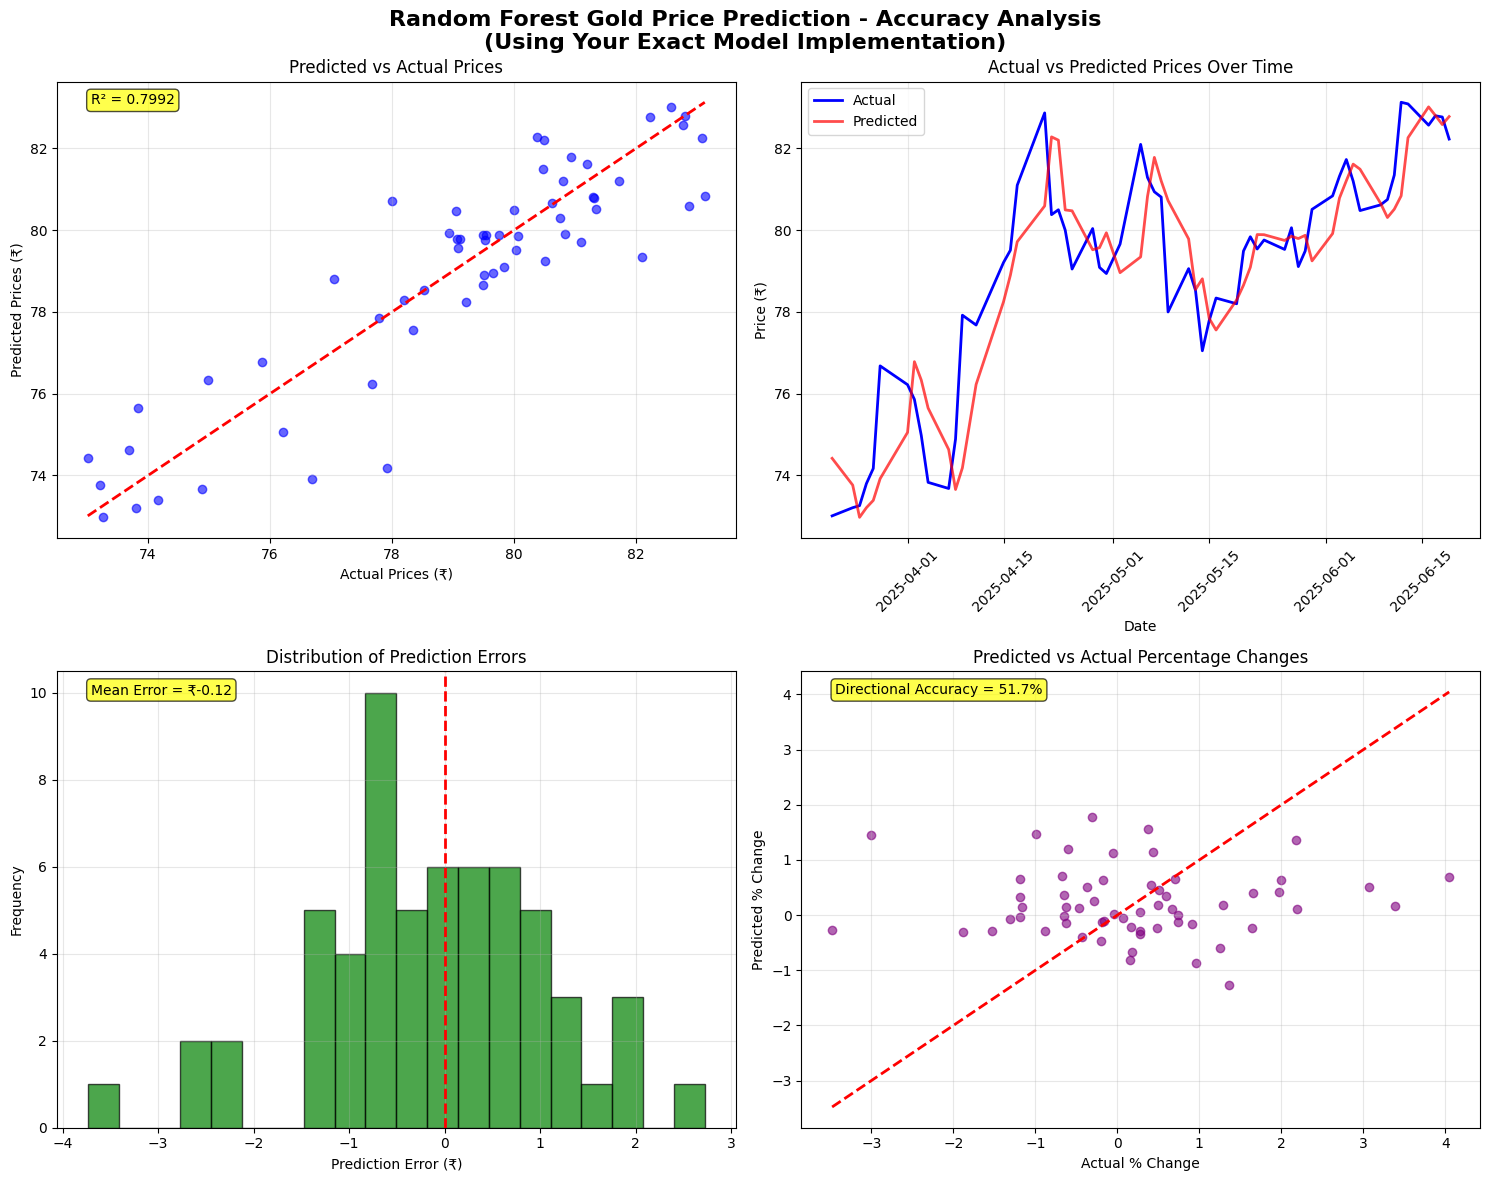

In [27]:
accuracy_results = check_your_random_forest_accuracy(gold, test_days=60)

Model evaluation code for LSTM

In [28]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Your existing classes (copy from your code)
class GoldPriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

def evaluate_your_lstm_model(gold_df, test_days=30, sequence_length=10, epochs=50, batch_size=16, lr=0.001):
    """
    Evaluate accuracy of YOUR existing LSTM model by testing on historical data
    
    Parameters:
    - gold_df: Your gold DataFrame with all required features
    - test_days: Number of recent days to test predictions on
    - sequence_length, epochs, batch_size, lr: Same parameters as your model
    
    Returns:
    - Dictionary with accuracy metrics and detailed results
    """
    
    # Same feature columns as your original function
    feature_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment'
    ]
    
    print(f"Evaluating YOUR LSTM model accuracy on last {test_days} trading days...")
    print("=" * 70)
    
    # Check if required columns exist
    required_cols = ['Close'] + feature_cols
    missing_cols = [col for col in required_cols if col not in gold_df.columns]
    if missing_cols:
        print(f"ERROR: Missing columns in your data: {missing_cols}")
        return None
    
    # Store results
    predictions = []
    actuals = []
    dates = []
    errors = []
    
    # Walk-forward validation - test on multiple historical days
    for day_back in range(test_days, 0, -1):
        try:
            print(f"Testing day {test_days - day_back + 1}/{test_days}...", end=" ")
            
            # Create training data (everything up to test date)
            test_date_idx = len(gold_df) - day_back
            train_data = gold_df.iloc[:test_date_idx].copy()
            
            if len(train_data) < sequence_length + 100:  # Need minimum data
                print("Insufficient data")
                continue
            
            # Get test date and actual next day price
            test_date = gold_df.index[test_date_idx]
            if test_date_idx < len(gold_df) - 1:
                actual_next_price = gold_df['Close'].iloc[test_date_idx]
            else:
                print("No next day data")
                continue
            
            # Apply your exact data processing steps
            gold_subset = train_data[['Close'] + feature_cols].dropna()
            gold_subset = gold_subset.asfreq('B')
            gold_subset.ffill(inplace=True)
            gold_subset['Target'] = gold_subset['Close'].shift(-1)
            gold_subset.dropna(inplace=True)
            
            if len(gold_subset) < sequence_length + 10:
                print("Insufficient processed data")
                continue
            
            # Your exact scaling approach
            scaler = MinMaxScaler()
            X_scaled = scaler.fit_transform(gold_subset[feature_cols])
            y_scaled = scaler.fit_transform(gold_subset[['Target']])
            
            # Create sequences exactly like your code
            X_seq, y_seq = [], []
            for i in range(len(X_scaled) - sequence_length):
                X_seq.append(X_scaled[i:i + sequence_length])
                y_seq.append(y_scaled[i + sequence_length])
            
            X_seq = np.array(X_seq)
            y_seq = np.array(y_seq)
            
            if len(X_seq) == 0:
                print("No sequences created")
                continue
            
            # Train model exactly like your code
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model = LSTMModel(input_size=X_seq.shape[2]).to(device)
            
            train_ds = GoldPriceDataset(X_seq, y_seq)
            train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
            
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            
            model.train()
            for epoch in range(epochs):
                for xb, yb in train_dl:
                    xb, yb = xb.to(device), yb.to(device)
                    optimizer.zero_grad()
                    output = model(xb).squeeze()
                    loss = criterion(output, yb.squeeze())
                    loss.backward()
                    optimizer.step()
            
            # Make prediction exactly like your code
            model.eval()
            last_seq = torch.tensor(X_scaled[-sequence_length:], dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                next_pred = model(last_seq).cpu().numpy()
            
            # Inverse transform exactly like your code
            predicted_price = scaler.inverse_transform(
                np.concatenate([np.zeros((1, len(feature_cols))), next_pred], axis=1)
            )[:, -1][0]
            
            # Store results
            predictions.append(predicted_price)
            actuals.append(actual_next_price)
            dates.append(test_date)
            
            error = abs(predicted_price - actual_next_price)
            errors.append(error)
            
            print(f"Pred: ₹{predicted_price:.2f}, Actual: ₹{actual_next_price:.2f}, Error: ₹{error:.2f}")
            
        except Exception as e:
            print(f"Error: {str(e)}")
            continue
    
    if len(predictions) == 0:
        print("No valid predictions generated!")
        return None
    
    # Convert to numpy arrays
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Calculate accuracy metrics
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    r2 = r2_score(actuals, predictions)
    
    # Calculate direction accuracy
    if len(predictions) > 1:
        # Get previous prices for direction calculation
        prev_prices = []
        for i, date in enumerate(dates):
            date_idx = gold_df.index.get_loc(date)
            if date_idx > 0:
                prev_prices.append(gold_df['Close'].iloc[date_idx - 1])
            else:
                prev_prices.append(actuals[i])  # fallback
        
        prev_prices = np.array(prev_prices)
        
        # Actual direction (up/down from previous day)
        actual_directions = np.sign(actuals - prev_prices)
        # Predicted direction (up/down from previous day)  
        pred_directions = np.sign(predictions - prev_prices)
        
        # Direction accuracy
        direction_accuracy = np.mean(actual_directions == pred_directions) * 100
    else:
        direction_accuracy = 0
    
    # Print detailed results
    print("\n" + "=" * 70)
    print("YOUR LSTM MODEL ACCURACY EVALUATION RESULTS")
    print("=" * 70)
    print(f"Test Period: {test_days} days requested, {len(predictions)} valid predictions")
    print(f"Date Range: {dates[0].strftime('%Y-%m-%d')} to {dates[-1].strftime('%Y-%m-%d')}")
    print()
    print("ACCURACY METRICS:")
    print(f"├─ Mean Absolute Error (MAE): ₹{mae:.2f}")
    print(f"├─ Root Mean Squared Error (RMSE): ₹{rmse:.2f}")
    print(f"├─ Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"├─ R² Score (Coefficient of Determination): {r2:.4f}")
    print(f"└─ Direction Accuracy: {direction_accuracy:.1f}%")
    print()
    print("PRICE STATISTICS:")
    print(f"├─ Average Actual Price: ₹{np.mean(actuals):.2f}")
    print(f"├─ Average Predicted Price: ₹{np.mean(predictions):.2f}")
    print(f"├─ Average Error: ₹{np.mean(errors):.2f}")
    print(f"├─ Max Error: ₹{np.max(errors):.2f}")
    print(f"└─ Min Error: ₹{np.min(errors):.2f}")
    
    # Performance assessment
    if mape < 5:
        performance = "🟢 EXCELLENT"
    elif mape < 10:
        performance = "🟡 GOOD"
    elif mape < 20:
        performance = "🟠 FAIR"
    else:
        performance = "🔴 POOR"
    
    print(f"\nOVERALL PERFORMANCE: {performance}")
    print("=" * 70)
    
    # Create results dictionary
    results = {
        'predictions': predictions,
        'actuals': actuals,
        'dates': dates,
        'errors': errors,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'r2_score': r2,
        'direction_accuracy': direction_accuracy,
        'test_days': len(predictions),
        'avg_actual': np.mean(actuals),
        'avg_predicted': np.mean(predictions),
        'avg_error': np.mean(errors),
        'max_error': np.max(errors),
        'min_error': np.min(errors)
    }
    
    return results

def plot_your_lstm_results(results):
    """Plot the accuracy results for your LSTM model"""
    
    predictions = results['predictions']
    actuals = results['actuals']
    dates = results['dates']
    errors = results['errors']
    
    # Set up the plotting style
    plt.style.use('default')
    fig = plt.figure(figsize=(16, 12))
    
    # Create a 2x3 grid
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # 1. Time Series: Predicted vs Actual
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(dates, actuals, label='Actual Prices', color='#2E86AB', linewidth=2.5, marker='o', markersize=4)
    ax1.plot(dates, predictions, label='LSTM Predictions', color='#A23B72', linewidth=2.5, marker='s', markersize=4)
    ax1.fill_between(dates, actuals, predictions, alpha=0.2, color='gray')
    ax1.set_title('Your LSTM Model: Predicted vs Actual Gold Prices', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price (₹)')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # 2. Scatter Plot: Perfect Prediction Line
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.scatter(actuals, predictions, alpha=0.7, color='#F18F01', s=50, edgecolor='black', linewidth=0.5)
    min_price = min(min(actuals), min(predictions))
    max_price = max(max(actuals), max(predictions))
    ax2.plot([min_price, max_price], [min_price, max_price], 'r--', linewidth=2, label='Perfect Prediction')
    ax2.set_title('Predicted vs Actual Scatter Plot')
    ax2.set_xlabel('Actual Price (₹)')
    ax2.set_ylabel('Predicted Price (₹)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add R² on the plot
    ax2.text(0.05, 0.95, f'R² = {results["r2_score"]:.4f}', transform=ax2.transAxes, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=10)
    
    # 3. Prediction Errors
    ax3 = fig.add_subplot(gs[1, 1])
    colors = ['#FF6B6B' if e > np.mean(errors) else '#4ECDC4' for e in errors]
    bars = ax3.bar(range(len(errors)), errors, color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
    ax3.set_title('Prediction Errors (|Predicted - Actual|)')
    ax3.set_xlabel('Test Day')
    ax3.set_ylabel('Absolute Error (₹)')
    ax3.axhline(y=np.mean(errors), color='red', linestyle='--', alpha=0.8, label=f'Avg Error: ₹{np.mean(errors):.2f}')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Error Distribution
    ax4 = fig.add_subplot(gs[2, 0])
    prediction_errors = predictions - actuals  # Signed errors
    ax4.hist(prediction_errors, bins=min(15, len(prediction_errors)//2), alpha=0.7, color='#9B59B6', 
             edgecolor='black', linewidth=0.5)
    ax4.set_title('Error Distribution (Predicted - Actual)')
    ax4.set_xlabel('Error (₹)')
    ax4.set_ylabel('Frequency')
    ax4.axvline(x=0, color='black', linestyle='--', alpha=0.7, label='Perfect Prediction')
    ax4.axvline(x=np.mean(prediction_errors), color='red', linestyle='-', alpha=0.8, 
                label=f'Mean Error: ₹{np.mean(prediction_errors):.2f}')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Performance Metrics Bar Chart
    ax5 = fig.add_subplot(gs[2, 1])
    metrics = ['MAE\n(₹)', 'RMSE\n(₹)', 'MAPE\n(%)', 'R² Score\n(0-1)', 'Direction\nAccuracy (%)']
    values = [results['mae'], results['rmse'], results['mape'], 
              results['r2_score'], results['direction_accuracy']]
    
    colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFD700', '#FF99CC']
    bars = ax5.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax5.set_title('Your LSTM Model Performance Metrics')
    ax5.set_ylabel('Value')
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + max(values)*0.01,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.setp(ax5.xaxis.get_majorticklabels(), rotation=0, ha='center')
    ax5.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Your LSTM Gold Price Prediction Model - Accuracy Analysis', 
                fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()

def run_your_lstm_evaluation(gold_dataframe, test_days=30, plot_results=True):
    """
    Main function to evaluate YOUR LSTM model
    
    Usage:
    # Load your gold price data
    gold_df = pd.read_csv('your_gold_data.csv', index_col=0, parse_dates=True)
    
    # Run evaluation
    results = run_your_lstm_evaluation(gold_df, test_days=30)
    """
    
    print("🔍 EVALUATING YOUR LSTM GOLD PRICE PREDICTION MODEL")
    print("=" * 70)
    print(f"📊 Data shape: {gold_dataframe.shape}")
    print(f"📅 Date range: {gold_dataframe.index.min()} to {gold_dataframe.index.max()}")
    print(f"🎯 Testing on last {test_days} trading days")
    print()
    
    # Run the evaluation
    results = evaluate_your_lstm_model(gold_dataframe, test_days=test_days)
    
    if results:
        # Plot results if requested
        if plot_results:
            plot_your_lstm_results(results)
        
        # Provide actionable insights
        print("\n📋 ACTIONABLE INSIGHTS:")
        print("=" * 70)
        
        if results['mape'] < 5:
            print("✅ Your model has EXCELLENT accuracy! Consider using it for trading decisions.")
        elif results['mape'] < 10:
            print("✅ Your model has GOOD accuracy. It's reliable for general price trends.")
        elif results['mape'] < 20:
            print("⚠️  Your model has FAIR accuracy. Use with caution and combine with other indicators.")
        else:
            print("❌ Your model has POOR accuracy. Consider:")
            print("   • Adding more features (technical indicators, market sentiment)")
            print("   • Increasing training data")
            print("   • Tuning hyperparameters (sequence_length, epochs, hidden_size)")
            print("   • Using different model architecture")
        
        if results['direction_accuracy'] > 60:
            print(f"✅ Good directional accuracy ({results['direction_accuracy']:.1f}%) - useful for trend prediction")
        else:
            print(f"⚠️  Low directional accuracy ({results['direction_accuracy']:.1f}%) - focus on improving trend prediction")
        
        print(f"\n💡 On average, your model's predictions are off by ₹{results['avg_error']:.2f}")
        print(f"📈 Your model explains {results['r2_score']*100:.1f}% of price variance")
        
        return results
    else:
        print("❌ Evaluation failed! Check your data and try again.")
        return None

# Quick comparison function
def compare_your_model_performance(gold_dataframe):
    """Compare your model's performance across different test periods"""
    
    test_periods = [7, 14, 30]
    results_comparison = {}
    
    print("📊 COMPARING YOUR LSTM MODEL ACROSS DIFFERENT TEST PERIODS")
    print("=" * 70)
    
    for period in test_periods:
        print(f"\n🔍 Testing {period}-day period...")
        results = evaluate_your_lstm_model(gold_dataframe, test_days=period)
        
        if results:
            results_comparison[f"{period}_days"] = {
                'mape': results['mape'],
                'mae': results['mae'],
                'direction_accuracy': results['direction_accuracy'],
                'valid_predictions': results['test_days']
            }
    
    # Print comparison
    if results_comparison:
        print("\n📋 PERFORMANCE COMPARISON:")
        print("=" * 50)
        print(f"{'Period':<10} {'MAPE (%)':<10} {'MAE (₹)':<10} {'Direction (%)':<12} {'Valid Tests':<12}")
        print("-" * 50)
        
        for period, metrics in results_comparison.items():
            period_name = period.replace('_', ' ')
            print(f"{period_name:<10} {metrics['mape']:<10.2f} {metrics['mae']:<10.2f} "
                  f"{metrics['direction_accuracy']:<12.1f} {metrics['valid_predictions']:<12}")
    
    return results_comparison

🔍 EVALUATING YOUR LSTM GOLD PRICE PREDICTION MODEL
📊 Data shape: (3742, 22)
📅 Date range: 2010-04-22 00:00:00 to 2025-06-20 00:00:00
🎯 Testing on last 30 trading days

Evaluating YOUR LSTM model accuracy on last 30 trading days...
Testing day 1/30... Pred: ₹80.83, Actual: ₹78.00, Error: ₹2.83
Testing day 2/30... Pred: ₹81.63, Actual: ₹79.06, Error: ₹2.57
Testing day 3/30... Pred: ₹79.97, Actual: ₹78.53, Error: ₹1.44
Testing day 4/30... Pred: ₹79.82, Actual: ₹77.05, Error: ₹2.77
Testing day 5/30... Pred: ₹78.99, Actual: ₹77.79, Error: ₹1.20
Testing day 6/30... Pred: ₹77.29, Actual: ₹78.34, Error: ₹1.05
Testing day 7/30... Pred: ₹78.23, Actual: ₹78.20, Error: ₹0.03
Testing day 8/30... Pred: ₹77.78, Actual: ₹79.49, Error: ₹1.71
Testing day 9/30... Pred: ₹77.30, Actual: ₹79.84, Error: ₹2.54
Testing day 10/30... Pred: ₹77.78, Actual: ₹79.54, Error: ₹1.76
Testing day 11/30... Pred: ₹78.68, Actual: ₹79.76, Error: ₹1.08
Testing day 12/30... Pred: ₹79.38, Actual: ₹79.53, Error: ₹0.15
Testing da

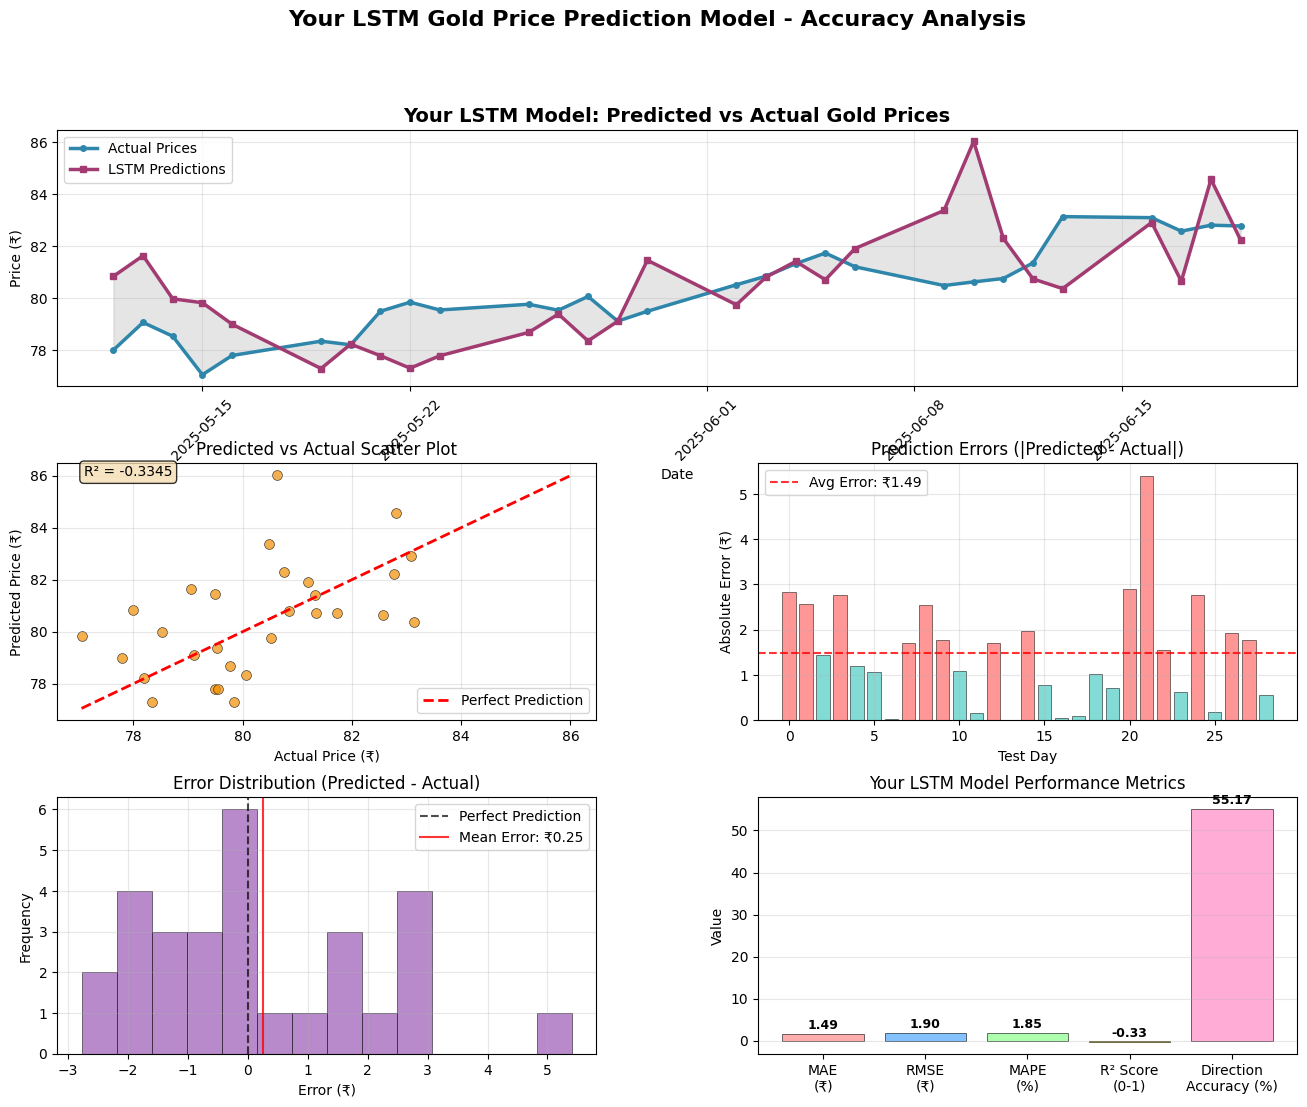


📋 ACTIONABLE INSIGHTS:
✅ Your model has EXCELLENT accuracy! Consider using it for trading decisions.
⚠️  Low directional accuracy (55.2%) - focus on improving trend prediction

💡 On average, your model's predictions are off by ₹1.49
📈 Your model explains -33.4% of price variance


In [29]:
  
# Run evaluation
results = run_your_lstm_evaluation(gold, test_days=30)